# Using Convolutional Neural Networks (CNN) to Estimate Skribll Drawings

Using wget commands to retrive data from a storage from cloud


In [1]:
!mkdir data

In [2]:
%cd data

/kaggle/working/data


In [3]:
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/calculator.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camera.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/computer.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/envelope.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/headphones.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/mouse.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/radio.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/spreadsheet.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/telephone.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/television.npy

--2024-02-14 14:54:19--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.142.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93581456 (89M) [application/octet-stream]
Saving to: 'book.npy'

book.npy            100%[===================>]  89.25M   162MB/s    in 0.6s    

2024-02-14 14:54:20 (162 MB/s) - 'book.npy' saved [93581456/93581456]

--2024-02-14 14:54:21--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/calculator.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.142.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100646080 (96M) [application/octet-stream]
Savi

In [4]:
!ls

book.npy	computer.npy	laptop.npy  spreadsheet.npy
calculator.npy	envelope.npy	mouse.npy   telephone.npy
camera.npy	headphones.npy	radio.npy   television.npy


In [5]:
%cd

/root


In [6]:
from sklearn.model_selection import train_test_split as train_test_split
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
#from keras.utils import np_utils
from random import randint
import numpy as np
import os
from PIL import Image
from tensorflow.keras.utils import to_categorical # this is changed to to_categorical

2024-02-14 14:54:47.327541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 14:54:47.327641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 14:54:47.462658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Creates a dictionary with all the categories.
CATEGORIES = { 
    0: "Book",
    1: "Calculator",
    2: "Camera",
    3: "Computer",
    4: "Envelope",
    5: "Headphones",
    6: "Laptop",
    7: "Mouse",
    8: "Radio",
    9: "Spreadsheet",
    10: "Telephone",
    11: "Television",
}
N_CATEGORIES = len(CATEGORIES)

# Defines the number of drawings per category to take in.
N = 7500

# Defines the number of epochs (iterations of training) the model will undergo.
N_EPOCHS = 10

# The files to learn from. They MUST match the information in CATEGORIES for proper classification.
files = ["book.npy", "calculator.npy", "camera.npy", "computer.npy", "envelope.npy", "headphones.npy", "laptop.npy", "mouse.npy", "radio.npy", "spreadsheet.npy", "telephone.npy", "television.npy"]

In [8]:
def load(dir,reshaped, files):
  # Takes the .npy files and return them as arrays.
  data = [ ]
  for file in files:
    f = np.load(dir + file)
    if reshaped:
      new_f =[]
      for i in range(len(f)):
        x = np.reshape(f[i], (28,28))
        x = np.expand_dims(x, axis = 0)
        x = np.reshape(f[i], (28,28,1))
        new_f.append(x)
      f = new_f
    data.append(f)
  return data

def normalize(data):
  # Takes a list ot a list of lists and returns its normalized form.
  return np.interp(data, [0,255],[-1,1])

def denormalize(data):
  # Takes a list ot a list of lists and returns its denormalized form.
  return np.interp(data,[-1,1],[0,255])

def visualize(array):
  # Visualizes a 2D array as an Image.
  array = np.reshape(array, (28,28))
  img = Image.fromarray(array)
  return img 

def set_limit(arrays, n):
  # Limits the elements from each array up to the nth element and returns a single list.
  new = []
  for array in arrays:
    i = 0
    for item in array:
      if i == n:
        break
      new.append(item)
      i += 1
  return new

def make_labels(N1, N2):
  # Make labels from 0 to N1, each repeated N2 times.
  labels = []
  for i in range(N1):
    labels += [i] *N2
  return labels

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotFromHistory(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [10]:
images = load("/kaggle/working/data/", False, ["book.npy"])

In [11]:
visualize(images[0][0])

In [12]:
# Loads the content into /content/data/ while reshaping images to 28 x 28 (second True argument). A ConvNet expects this format.

# the directory can be changed to content/data
images = load("/kaggle/working/data/", True, files)

images = set_limit(images, N)
# Normalizes the values and makes the values -1 to 1. This ensures better performance of the model.
images = list(map(normalize, images))

labels = make_labels(N_CATEGORIES, N)

# Reserves 5 percent of the dataset for training purposes only (test_size) and splits the data into training and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.05)

# Performs one-hot encoding.
Y_train = to_categorical(y_train, N_CATEGORIES)
Y_test = to_categorical(y_test, N_CATEGORIES)

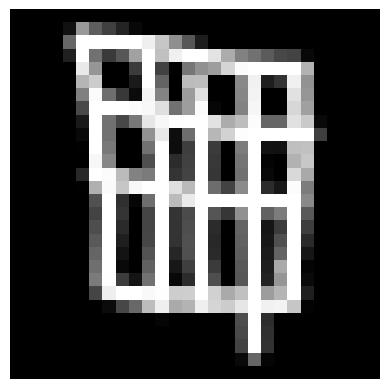

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the first image
plt.imshow(x_train[1], cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

We find out that 28x28 px is blurry and less representative of the data, hence we increase the px to 64x64

In [14]:
import cv2

# Resize images to the desired shape (64x64 pixels)
resized_x_train = [cv2.resize(image, (64, 64)) for image in x_train]
resized_x_test = [cv2.resize(image, (64, 64)) for image in x_test]

# Reshape images to add the channel dimension (1 for grayscale)
resized_x_train = np.array(resized_x_train).reshape(-1, 64, 64, 1)
resized_x_test = np.array(resized_x_test).reshape(-1, 64, 64, 1)

# Now you can use resized_x_train and resized_x_test as input to your model

In [15]:
def load(dir,reshaped, files):
  # Takes the .npy files and return them as arrays.
  data = [ ]
  for file in files:
    f = np.load(dir + file)
    if reshaped:
      new_f =[]
      for i in range(len(f)):
        x = np.reshape(f[i], (64,64))
        x = np.expand_dims(x, axis = 0)
        x = np.reshape(f[i], (64,64,1))
        new_f.append(x)
      f = new_f
    data.append(f)
  return data

def normalize(data):
  # Takes a list ot a list of lists and returns its normalized form.
  return np.interp(data, [0,255],[-1,1])

def denormalize(data):
  # Takes a list ot a list of lists and returns its denormalized form.
  return np.interp(data,[-1,1],[0,255])

def visualize(array):
  # Visualizes a 2D array as an Image.
  array = np.reshape(array, (64,64))
  img = Image.fromarray(array)
  return img 

def set_limit(arrays, n):
  # Limits the elements from each array up to the nth element and returns a single list.
  new = []
  for array in arrays:
    i = 0
    for item in array:
      if i == n:
        break
      new.append(item)
      i += 1
  return new

def make_labels(N1, N2):
  # Make labels from 0 to N1, each repeated N2 times.
  labels = []
  for i in range(N1):
    labels += [i] *N2
  return labels

In [16]:
resized_x_train.shape

(85500, 64, 64, 1)

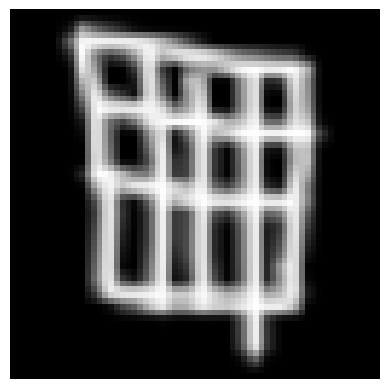

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape the array
image_array = resized_x_train.reshape((85500, 64, 64))

# Plot the first image
plt.imshow(image_array[1], cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

In [18]:
import matplotlib.pyplot as plt

def plotFromHistories(histories, title, hyperparam_name, hyperparam_values):
    plt.figure(figsize=(16, 8))

    # Plotting accuracy
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        acc = history.history['accuracy']
        plt.plot(range(1, len(acc) + 1), acc, 'o-', label=f'Training Accuracy ({hyperparam_name} = {hyperparam_values[i]})')

    plt.title(f'Training Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(1, len(acc) + 1))

    # Plotting validation accuracy
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        val_acc = history.history['val_accuracy']
        plt.plot(range(1, len(val_acc) + 1), val_acc, 'o-', label=f'Validation Accuracy ({hyperparam_name} = {hyperparam_values[i]})')

    plt.title(f'Validation Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(1, len(val_acc) + 1))

    # Plotting loss
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        loss = history.history['loss']
        plt.plot(range(1, len(loss) + 1), loss, 'o-', label=f'Training Loss ({hyperparam_name} = {hyperparam_values[i]})')

    plt.title(f'Training Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(1, len(loss) + 1))

    # Plotting validation loss
    plt.subplot(2, 2, 4)
    for i, history in enumerate(histories):
        val_loss = history.history['val_loss']
        plt.plot(range(1, len(val_loss) + 1), val_loss, 'o-', label=f'Validation Loss ({hyperparam_name} = {hyperparam_values[i]})')

    plt.title(f'Validation Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(1, len(val_loss) + 1))

    # Show the plots
    plt.tight_layout()
    plt.show()

In [19]:
# pip install -U neptune-tensorflow-keras

In [20]:
# pip install neptune-client

### Adding Validation Split

This is to ensure that the model is able to generalise to unseen data

In [10]:
# import tensorflow as tf

# import neptune
# import neptune

# run = neptune.init_run(
#     project="samuelkoh17/LSTM-Sentimental-Analysis",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MDQ5OTJhYy1hMzAyLTQ1YWMtYThhZC05NTgyNWYxNjcyZjAifQ==",
# )  # your credentials

https://app.neptune.ai/samuelkoh17/LSTM-Sentimental-Analysis/e/LSTMSEN-5


In [ ]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3 , 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))


In [20]:
%cd /content

[Errno 2] No such file or directory: '/content'
/root


In [22]:
# # Compiles and trains the model; the fit() function is the most important in actually creating the model.
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
# model.fit(np.array(x_train), np.array(Y_train), batch_size=32, epochs=N_EPOCHS)
# print("Training complete")

# # Evaluates the performance of the model by passing a test image into it.
# print("Evaluating model")
# preds = model.predict(np.array(x_test))

# # Calculates an accuracy score and displays it.
# score = 0
# for i in range(len(preds)):
#   if np.argmax(preds[i]) == y_test[i]:
#     score += 1
# print("Accuracy:", ((score + 0.0)/ len(preds)) * 100)

# # Saves the model as a Keras H5 (.h5) file.
# model.save("model.h5")
# print("Model saved")

In [23]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
history = model.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.5630 - accuracy: 0.8238 - val_loss: 0.4194 - val_accuracy: 0.8687
Epoch 2/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.5292 - accuracy: 0.8327 - val_loss: 0.4202 - val_accuracy: 0.8686
Epoch 3/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.5107 - accuracy: 0.8374 - val_loss: 0.4451 - val_accuracy: 0.8621
Epoch 4/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.4875 - accuracy: 0.8423 - val_loss: 0.4438 - val_accuracy: 0.8708
Epoch 5/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.4771 - accuracy: 0.8459 - val_loss: 0.4884 - val_accuracy: 0.8663
Epoch 6/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.4656 - accuracy: 0.8487 - val_loss: 0.4574 - val_accuracy: 0.8647
Epoch 7/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.4547 - accuracy: 0.8513 - val_loss: 0.4935 - val_accuracy:

### Tuning Model Architecture

In [63]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
#model.add(Conv2D(32, (3,3), activation="relu"))
#model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelArc0 = model

In [49]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelInputShape1 = model

In [55]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3 , 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelArc2 = model

In [57]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3 , 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelArc3 = model

In [64]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyArc0 = modelArc0.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.5796 - accuracy: 0.8191 - val_loss: 0.4748 - val_accuracy: 0.8524
Epoch 2/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.3885 - accuracy: 0.8758 - val_loss: 0.4661 - val_accuracy: 0.8572
Epoch 3/10
2138/2138 [==============================] - 8s 4ms/step - loss: 0.2980 - accuracy: 0.9026 - val_loss: 0.4986 - val_accuracy: 0.8604
Epoch 4/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.2201 - accuracy: 0.9264 - val_loss: 0.5746 - val_accuracy: 0.8547
Epoch 5/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.1672 - accuracy: 0.9434 - val_loss: 0.7488 - val_accuracy: 0.8530
Epoch 6/10
2138/2138 [==============================] - 8s 4ms/step - loss: 0.1377 - accuracy: 0.9529 - val_loss: 0.9511 - val_accuracy: 0.8549
Epoch 7/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.1218 - accuracy: 0.9611 - val_loss: 0.8594 - val_accuracy

In [50]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
history = modelInputShape1.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 11s 4ms/step - loss: 0.5671 - accuracy: 0.8214 - val_loss: 0.4566 - val_accuracy: 0.8475
Epoch 2/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.3643 - accuracy: 0.8845 - val_loss: 0.3805 - val_accuracy: 0.8783
Epoch 3/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.3019 - accuracy: 0.9015 - val_loss: 0.3660 - val_accuracy: 0.8854
Epoch 4/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.2516 - accuracy: 0.9155 - val_loss: 0.4038 - val_accuracy: 0.8812
Epoch 5/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.2090 - accuracy: 0.9270 - val_loss: 0.4148 - val_accuracy: 0.8792
Epoch 6/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.1689 - accuracy: 0.9403 - val_loss: 0.4851 - val_accuracy: 0.8735
Epoch 7/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.1437 - accuracy: 0.9492 - val_loss: 0.5670 - val_accuracy

In [56]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyArc2 = modelArc2.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.6124 - accuracy: 0.8079 - val_loss: 0.4432 - val_accuracy: 0.8637
Epoch 2/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.4134 - accuracy: 0.8689 - val_loss: 0.4204 - val_accuracy: 0.8699
Epoch 3/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.3624 - accuracy: 0.8831 - val_loss: 0.4310 - val_accuracy: 0.8681
Epoch 4/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.3295 - accuracy: 0.8920 - val_loss: 0.4363 - val_accuracy: 0.8709
Epoch 5/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.3015 - accuracy: 0.9001 - val_loss: 0.4626 - val_accuracy: 0.8685
Epoch 6/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.2832 - accuracy: 0.9054 - val_loss: 0.5180 - val_accuracy: 0.8659
Epoch 7/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.2593 - accuracy: 0.9131 - val_loss: 0.5426 - val_accurac

In [58]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyArc3 = modelArc3.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 13s 5ms/step - loss: 0.6479 - accuracy: 0.7933 - val_loss: 0.5016 - val_accuracy: 0.8451
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.4398 - accuracy: 0.8595 - val_loss: 0.4180 - val_accuracy: 0.8693
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3922 - accuracy: 0.8734 - val_loss: 0.4476 - val_accuracy: 0.8612
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3632 - accuracy: 0.8823 - val_loss: 0.4440 - val_accuracy: 0.8643
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3475 - accuracy: 0.8863 - val_loss: 0.4611 - val_accuracy: 0.8630
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3356 - accuracy: 0.8899 - val_loss: 0.4501 - val_accuracy: 0.8635
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3186 - accuracy: 0.8950 - val_loss: 0.4949 - val_ac

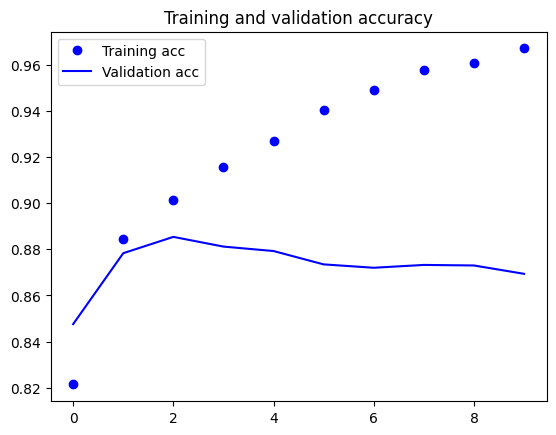

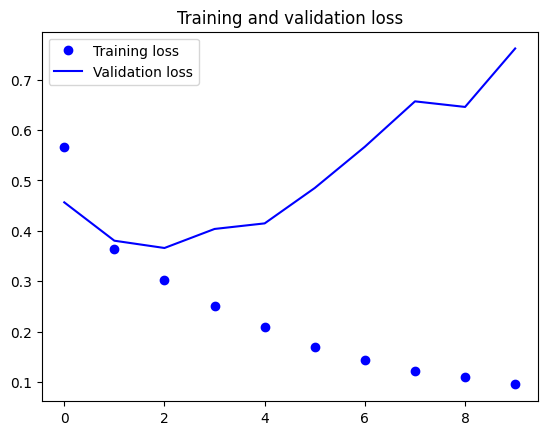

In [54]:
plotFromHistory(history)

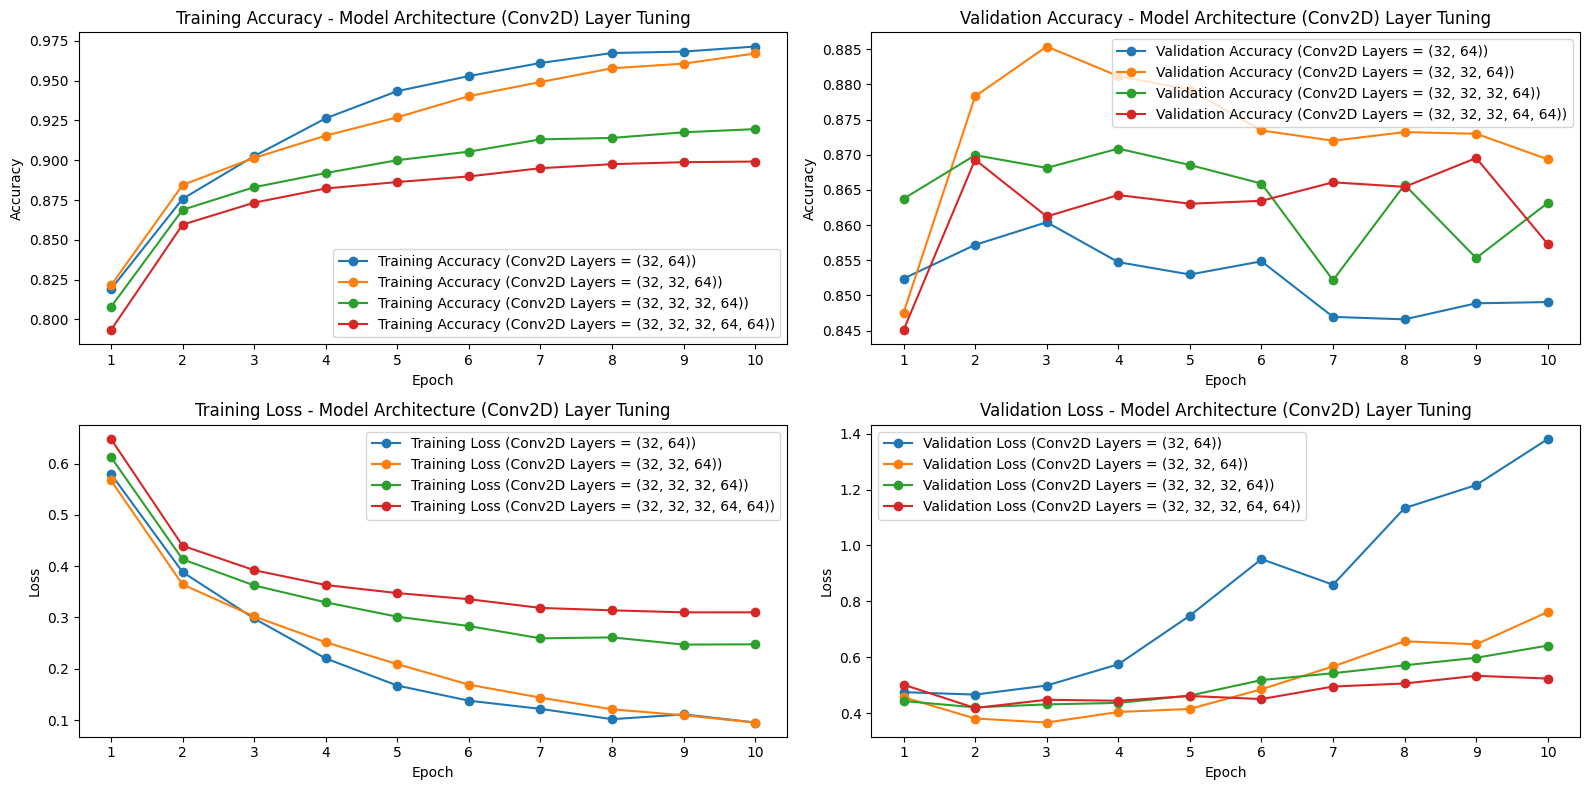

In [103]:
histories = [historyArc0, history, historyArc2, historyArc3]
title = 'Model Architecture (Conv2D) Layer Tuning'
hyperparam_name = 'Conv2D Layers'
hyperparam_values = [(32, 64), (32, 32, 64), (32, 32, 32, 64), (32, 32, 32, 64, 64)]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

### Removing Max Pooling

In [60]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
#model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelArc4 = model

In [61]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyArc4 = modelArc4.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 11s 4ms/step - loss: 0.6355 - accuracy: 0.8034 - val_loss: 0.5468 - val_accuracy: 0.8301
Epoch 2/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.5278 - accuracy: 0.8392 - val_loss: 0.5565 - val_accuracy: 0.8354
Epoch 3/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.5023 - accuracy: 0.8469 - val_loss: 0.6361 - val_accuracy: 0.8296
Epoch 4/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.4918 - accuracy: 0.8530 - val_loss: 0.6109 - val_accuracy: 0.8349
Epoch 5/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.5103 - accuracy: 0.8506 - val_loss: 0.7509 - val_accuracy: 0.8196
Epoch 6/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.5222 - accuracy: 0.8482 - val_loss: 0.7541 - val_accuracy: 0.8163
Epoch 7/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.5291 - accuracy: 0.8480 - val_loss: 0.9353 - val_accuracy

We observe that the model is getting confused as there were too much information that was not max pooled and summed up, hence leading to overfitting

In [74]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelDense1 = model

In [75]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelDense2 = model

In [76]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelDense3 = model

In [77]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelDense4 = model

In [78]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
modelDense5 = model

In [79]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyDense1 = modelDense1.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 11s 5ms/step - loss: 0.6239 - accuracy: 0.8023 - val_loss: 0.4514 - val_accuracy: 0.8594
Epoch 2/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.3932 - accuracy: 0.8751 - val_loss: 0.3837 - val_accuracy: 0.8794
Epoch 3/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.3364 - accuracy: 0.8921 - val_loss: 0.3876 - val_accuracy: 0.8830
Epoch 4/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.2953 - accuracy: 0.9044 - val_loss: 0.4026 - val_accuracy: 0.8789
Epoch 5/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.2595 - accuracy: 0.9136 - val_loss: 0.4202 - val_accuracy: 0.8729
Epoch 6/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.2342 - accuracy: 0.9211 - val_loss: 0.4012 - val_accuracy: 0.8831
Epoch 7/10
2138/2138 [==============================] - 9s 4ms/step - loss: 0.2103 - accuracy: 0.9276 - val_loss: 0.4466 - val_accurac

In [80]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyDense2 = modelDense2.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.6500 - accuracy: 0.7940 - val_loss: 0.4843 - val_accuracy: 0.8484
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.4115 - accuracy: 0.8688 - val_loss: 0.4313 - val_accuracy: 0.8573
Epoch 3/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.3546 - accuracy: 0.8850 - val_loss: 0.3905 - val_accuracy: 0.8781
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3203 - accuracy: 0.8972 - val_loss: 0.3852 - val_accuracy: 0.8806
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2914 - accuracy: 0.9054 - val_loss: 0.3959 - val_accuracy: 0.8791
Epoch 6/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.2624 - accuracy: 0.9138 - val_loss: 0.3840 - val_accuracy: 0.8837
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2460 - accuracy: 0.9190 - val_loss: 0.4089 - val_ac

In [81]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyDense3 = modelDense3.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.6311 - accuracy: 0.7983 - val_loss: 0.4430 - val_accuracy: 0.8581
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.4038 - accuracy: 0.8720 - val_loss: 0.3971 - val_accuracy: 0.8723
Epoch 3/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.3463 - accuracy: 0.8892 - val_loss: 0.3831 - val_accuracy: 0.8819
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3092 - accuracy: 0.9000 - val_loss: 0.3775 - val_accuracy: 0.8888
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2810 - accuracy: 0.9083 - val_loss: 0.3862 - val_accuracy: 0.8815
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2562 - accuracy: 0.9144 - val_loss: 0.4010 - val_accuracy: 0.8834
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2340 - accuracy: 0.9225 - val_loss: 0.4422 - val_ac

In [82]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyDense4 = modelDense4.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.6330 - accuracy: 0.7980 - val_loss: 0.4635 - val_accuracy: 0.8549
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.4048 - accuracy: 0.8709 - val_loss: 0.4021 - val_accuracy: 0.8708
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3502 - accuracy: 0.8864 - val_loss: 0.3747 - val_accuracy: 0.8815
Epoch 4/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.3126 - accuracy: 0.8993 - val_loss: 0.3844 - val_accuracy: 0.8812
Epoch 5/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.2832 - accuracy: 0.9074 - val_loss: 0.4223 - val_accuracy: 0.8763
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2581 - accuracy: 0.9148 - val_loss: 0.4110 - val_accuracy: 0.8839
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2361 - accuracy: 0.9206 - val_loss: 0.4090 - val_ac

In [83]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyDense5 = modelDense5.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.6053 - accuracy: 0.8065 - val_loss: 0.4528 - val_accuracy: 0.8539
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3854 - accuracy: 0.8761 - val_loss: 0.3964 - val_accuracy: 0.8782
Epoch 3/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.3249 - accuracy: 0.8944 - val_loss: 0.3733 - val_accuracy: 0.8844
Epoch 4/10
2138/2138 [==============================] - 10s 4ms/step - loss: 0.2843 - accuracy: 0.9063 - val_loss: 0.4111 - val_accuracy: 0.8815
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2517 - accuracy: 0.9155 - val_loss: 0.3919 - val_accuracy: 0.8838
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2193 - accuracy: 0.9258 - val_loss: 0.4277 - val_accuracy: 0.8829
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2009 - accuracy: 0.9317 - val_loss: 0.4510 - val_ac

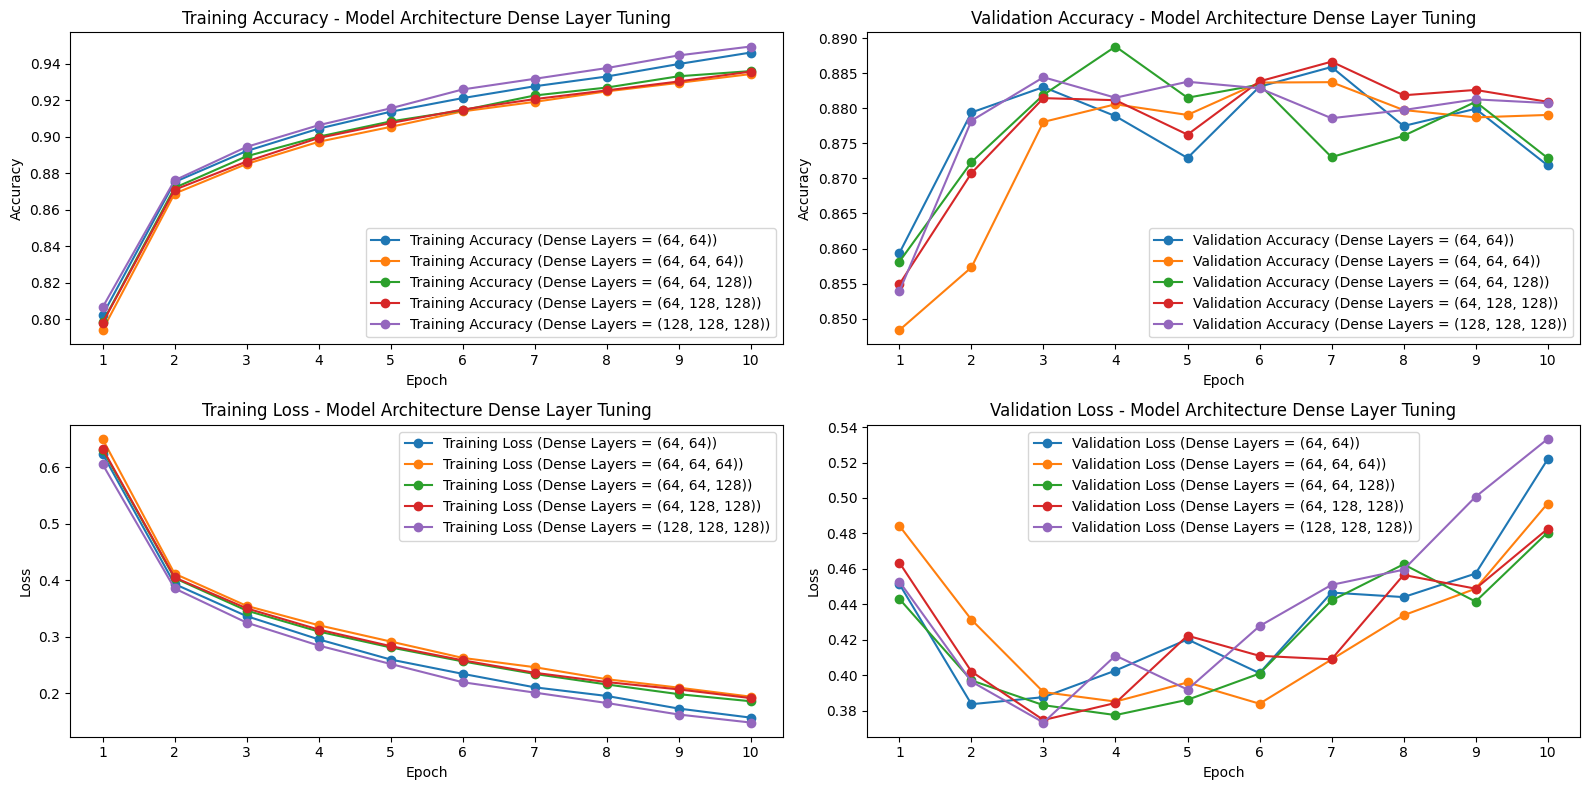

In [104]:
histories = [historyDense1, historyDense2, historyDense3, historyDense4, historyDense5]
title = 'Model Architecture Dense Layer Tuning'
hyperparam_name = 'Dense Layers'
hyperparam_values = [(64, 64), (64, 64, 64), (64, 64, 128), (64, 128, 128), (128, 128, 128)]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

We notice that 3 hidden layers can capture better patterns

In [89]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelDense6 = model

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_53 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 1600)            

In [90]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelDense7 = model

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_56 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_19 (Flatten)        (None, 1600)            

In [91]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelDense8 = model

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_59 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_20 (Flatten)        (None, 1600)            

In [92]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelDense9 = model

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_62 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_21 (Flatten)        (None, 1600)            

In [93]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyDense6 = modelDense6.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 13s 5ms/step - loss: 0.6024 - accuracy: 0.8052 - val_loss: 0.4472 - val_accuracy: 0.8562
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3827 - accuracy: 0.8778 - val_loss: 0.4010 - val_accuracy: 0.8767
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3238 - accuracy: 0.8952 - val_loss: 0.3756 - val_accuracy: 0.8848
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2828 - accuracy: 0.9069 - val_loss: 0.3901 - val_accuracy: 0.8846
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2545 - accuracy: 0.9159 - val_loss: 0.3886 - val_accuracy: 0.8826
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2281 - accuracy: 0.9241 - val_loss: 0.4454 - val_accuracy: 0.8832
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2063 - accuracy: 0.9316 - val_loss: 0.4253 - val_ac

In [94]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyDense7 = modelDense7.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.5968 - accuracy: 0.8093 - val_loss: 0.4655 - val_accuracy: 0.8573
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3849 - accuracy: 0.8776 - val_loss: 0.3838 - val_accuracy: 0.8806
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3290 - accuracy: 0.8948 - val_loss: 0.4019 - val_accuracy: 0.8779
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2899 - accuracy: 0.9059 - val_loss: 0.3874 - val_accuracy: 0.8850
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2570 - accuracy: 0.9152 - val_loss: 0.4017 - val_accuracy: 0.8861
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2298 - accuracy: 0.9220 - val_loss: 0.4125 - val_accuracy: 0.8873
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2065 - accuracy: 0.9298 - val_loss: 0.4483 - val_ac

In [95]:
historyDense8 = modelDense8.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.5819 - accuracy: 0.8139 - val_loss: 0.4404 - val_accuracy: 0.8599
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3773 - accuracy: 0.8797 - val_loss: 0.3723 - val_accuracy: 0.8839
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3128 - accuracy: 0.8982 - val_loss: 0.4004 - val_accuracy: 0.8747
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2701 - accuracy: 0.9108 - val_loss: 0.4057 - val_accuracy: 0.8837
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2345 - accuracy: 0.9219 - val_loss: 0.4075 - val_accuracy: 0.8801
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2036 - accuracy: 0.9312 - val_loss: 0.4440 - val_accuracy: 0.8828
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.1775 - accuracy: 0.9390 - val_loss: 0.4630 - val_ac

In [96]:
historyDense9 = modelDense9.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.5907 - accuracy: 0.8093 - val_loss: 0.4587 - val_accuracy: 0.8565
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3765 - accuracy: 0.8801 - val_loss: 0.3994 - val_accuracy: 0.8739
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3104 - accuracy: 0.8998 - val_loss: 0.3861 - val_accuracy: 0.8844
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2717 - accuracy: 0.9116 - val_loss: 0.4127 - val_accuracy: 0.8816
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2290 - accuracy: 0.9244 - val_loss: 0.4276 - val_accuracy: 0.8845
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.1998 - accuracy: 0.9327 - val_loss: 0.4339 - val_accuracy: 0.8819
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.1702 - accuracy: 0.9413 - val_loss: 0.4845 - val_ac

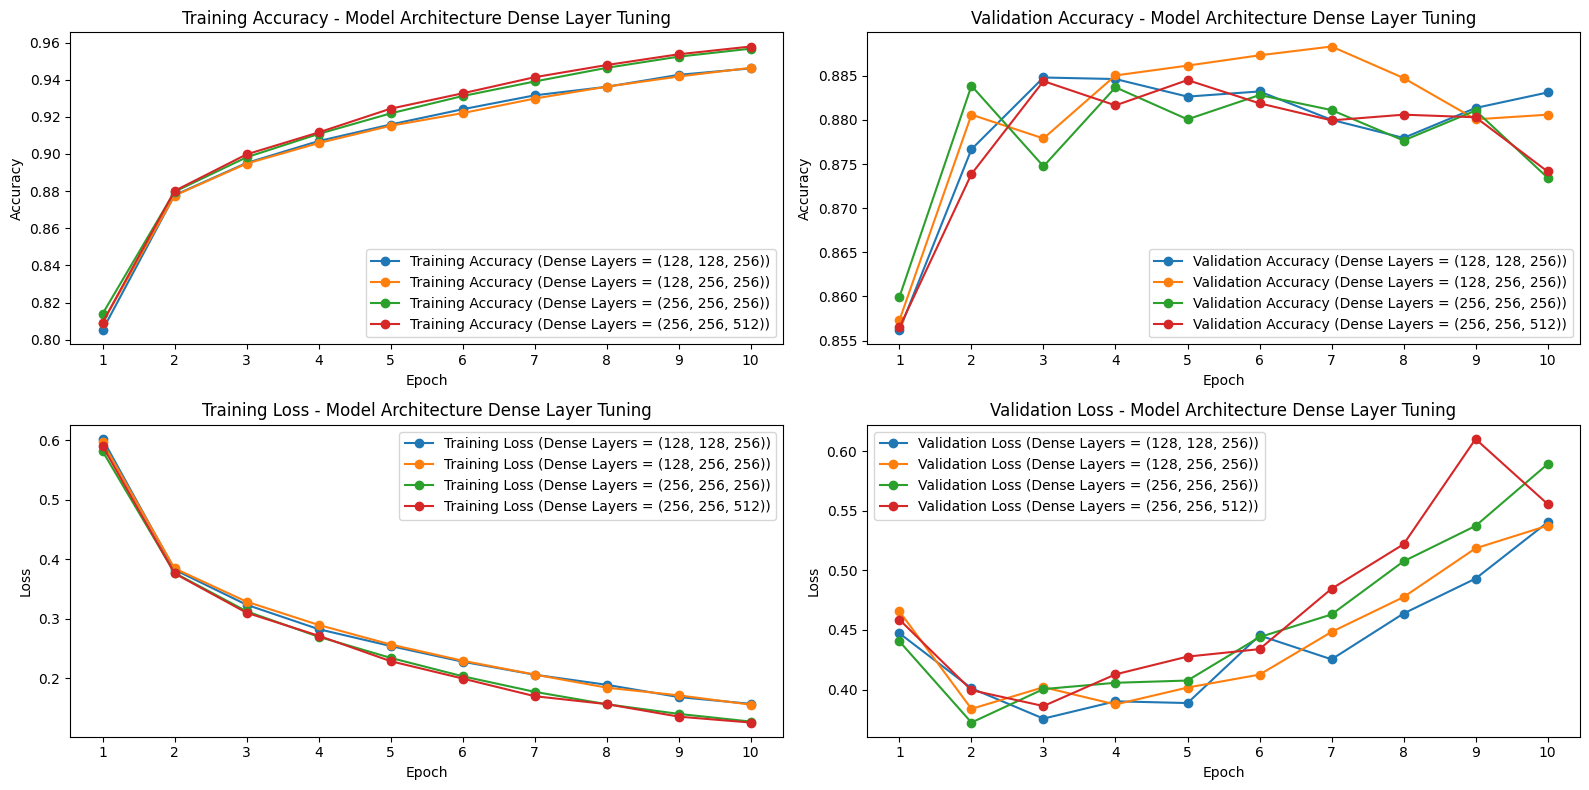

In [105]:
histories = [historyDense6, historyDense7, historyDense8, historyDense9]
title = 'Model Architecture Dense Layer Tuning'
hyperparam_name = 'Dense Layers'
hyperparam_values = [(128, 128, 256), (128, 256, 256), (256, 256, 256), (256, 256, 512)]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

In [107]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch1 = model

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_68 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_23 (Flatten)        (None, 1600)            

In [108]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch2 = model

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_71 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 1600)            

In [109]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch3 = model

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_74 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_75 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_25 (Flatten)        (None, 1600)            

In [110]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch4 = model

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_77 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_26 (Flatten)        (None, 1600)            

In [116]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch5 = model

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_80 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_81 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_27 (Flatten)        (None, 1600)            

In [117]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch6 = model

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_83 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_84 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_28 (Flatten)        (None, 1600)            

In [111]:
historyBatch1 = modelBatch1.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=4,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
17100/17100 [==============================] - 72s 4ms/step - loss: 0.5897 - accuracy: 0.8127 - val_loss: 0.4603 - val_accuracy: 0.8622
Epoch 2/10
17100/17100 [==============================] - 69s 4ms/step - loss: 0.4061 - accuracy: 0.8734 - val_loss: 0.4660 - val_accuracy: 0.8606
Epoch 3/10
17100/17100 [==============================] - 69s 4ms/step - loss: 0.3618 - accuracy: 0.8868 - val_loss: 0.4289 - val_accuracy: 0.8773
Epoch 4/10
17100/17100 [==============================] - 69s 4ms/step - loss: 0.3385 - accuracy: 0.8927 - val_loss: 0.4013 - val_accuracy: 0.8833
Epoch 5/10
17100/17100 [==============================] - 70s 4ms/step - loss: 0.3206 - accuracy: 0.8993 - val_loss: 0.4630 - val_accuracy: 0.8664
Epoch 6/10
17100/17100 [==============================] - 69s 4ms/step - loss: 0.3053 - accuracy: 0.9030 - val_loss: 0.4475 - val_accuracy: 0.8796
Epoch 7/10
17100/17100 [==============================] - 72s 4ms/step - loss: 0.2952 - accuracy: 0.9068 - val_loss: 0

In [112]:
historyBatch2 = modelBatch2.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 38s 4ms/step - loss: 0.5802 - accuracy: 0.8151 - val_loss: 0.4250 - val_accuracy: 0.8660
Epoch 2/10
8550/8550 [==============================] - 35s 4ms/step - loss: 0.3818 - accuracy: 0.8797 - val_loss: 0.4016 - val_accuracy: 0.8765
Epoch 3/10
8550/8550 [==============================] - 36s 4ms/step - loss: 0.3315 - accuracy: 0.8941 - val_loss: 0.3925 - val_accuracy: 0.8801
Epoch 4/10
8550/8550 [==============================] - 37s 4ms/step - loss: 0.2977 - accuracy: 0.9037 - val_loss: 0.3875 - val_accuracy: 0.8827
Epoch 5/10
8550/8550 [==============================] - 37s 4ms/step - loss: 0.2739 - accuracy: 0.9114 - val_loss: 0.3904 - val_accuracy: 0.8855
Epoch 6/10
8550/8550 [==============================] - 37s 4ms/step - loss: 0.2535 - accuracy: 0.9170 - val_loss: 0.4055 - val_accuracy: 0.8895
Epoch 7/10
8550/8550 [==============================] - 36s 4ms/step - loss: 0.2346 - accuracy: 0.9238 - val_loss: 0.4441 - val_ac

In [113]:
historyBatch3 = modelBatch3.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=16,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
4275/4275 [==============================] - 20s 4ms/step - loss: 0.6053 - accuracy: 0.8057 - val_loss: 0.4770 - val_accuracy: 0.8496
Epoch 2/10
4275/4275 [==============================] - 18s 4ms/step - loss: 0.4076 - accuracy: 0.8713 - val_loss: 0.4068 - val_accuracy: 0.8736
Epoch 3/10
4275/4275 [==============================] - 18s 4ms/step - loss: 0.3560 - accuracy: 0.8855 - val_loss: 0.4083 - val_accuracy: 0.8744
Epoch 4/10
4275/4275 [==============================] - 18s 4ms/step - loss: 0.3210 - accuracy: 0.8973 - val_loss: 0.3788 - val_accuracy: 0.8842
Epoch 5/10
4275/4275 [==============================] - 17s 4ms/step - loss: 0.2919 - accuracy: 0.9062 - val_loss: 0.4226 - val_accuracy: 0.8765
Epoch 6/10
4275/4275 [==============================] - 18s 4ms/step - loss: 0.2741 - accuracy: 0.9104 - val_loss: 0.4250 - val_accuracy: 0.8822
Epoch 7/10
4275/4275 [==============================] - 18s 4ms/step - loss: 0.2580 - accuracy: 0.9167 - val_loss: 0.4320 - val_ac

In [114]:
historyBatch4 = modelBatch4.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=64,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
1069/1069 [==============================] - 7s 5ms/step - loss: 0.6878 - accuracy: 0.7810 - val_loss: 0.4682 - val_accuracy: 0.8522
Epoch 2/10
1069/1069 [==============================] - 5s 5ms/step - loss: 0.4277 - accuracy: 0.8626 - val_loss: 0.4240 - val_accuracy: 0.8644
Epoch 3/10
1069/1069 [==============================] - 5s 5ms/step - loss: 0.3916 - accuracy: 0.8813 - val_loss: 0.4350 - val_accuracy: 0.8647
Epoch 4/10
1069/1069 [==============================] - 5s 5ms/step - loss: 0.3533 - accuracy: 0.8914 - val_loss: 0.4134 - val_accuracy: 0.8775
Epoch 5/10
1069/1069 [==============================] - 5s 5ms/step - loss: 0.3225 - accuracy: 0.8983 - val_loss: 0.3998 - val_accuracy: 0.8803
Epoch 6/10
1069/1069 [==============================] - 5s 5ms/step - loss: 0.2871 - accuracy: 0.9089 - val_loss: 0.4104 - val_accuracy: 0.8794
Epoch 7/10
1069/1069 [==============================] - 5s 5ms/step - loss: 0.2663 - accuracy: 0.9133 - val_loss: 0.4245 - val_accuracy:

In [118]:
historyBatch5 = modelBatch5.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=128,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
535/535 [==============================] - 5s 6ms/step - loss: 0.7435 - accuracy: 0.7648 - val_loss: 0.5055 - val_accuracy: 0.8345
Epoch 2/10
535/535 [==============================] - 3s 6ms/step - loss: 0.4419 - accuracy: 0.8598 - val_loss: 0.4507 - val_accuracy: 0.8546
Epoch 3/10
535/535 [==============================] - 3s 6ms/step - loss: 0.3808 - accuracy: 0.8777 - val_loss: 0.4058 - val_accuracy: 0.8727
Epoch 4/10
535/535 [==============================] - 3s 6ms/step - loss: 0.3442 - accuracy: 0.8897 - val_loss: 0.4014 - val_accuracy: 0.8752
Epoch 5/10
535/535 [==============================] - 3s 6ms/step - loss: 0.3167 - accuracy: 0.8979 - val_loss: 0.4669 - val_accuracy: 0.8742
Epoch 6/10
535/535 [==============================] - 3s 6ms/step - loss: 0.3218 - accuracy: 0.8994 - val_loss: 0.4728 - val_accuracy: 0.8682
Epoch 7/10
535/535 [==============================] - 3s 6ms/step - loss: 0.3005 - accuracy: 0.9042 - val_loss: 0.4068 - val_accuracy: 0.8735
Epoch 

In [119]:
historyBatch6 = modelBatch6.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=256,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
268/268 [==============================] - 5s 9ms/step - loss: 0.9331 - accuracy: 0.7023 - val_loss: 0.6708 - val_accuracy: 0.7807
Epoch 2/10
268/268 [==============================] - 2s 7ms/step - loss: 0.5173 - accuracy: 0.8375 - val_loss: 0.5083 - val_accuracy: 0.8415
Epoch 3/10
268/268 [==============================] - 2s 7ms/step - loss: 0.4338 - accuracy: 0.8630 - val_loss: 0.4779 - val_accuracy: 0.8519
Epoch 4/10
268/268 [==============================] - 2s 8ms/step - loss: 0.3856 - accuracy: 0.8775 - val_loss: 0.4460 - val_accuracy: 0.8555
Epoch 5/10
268/268 [==============================] - 2s 7ms/step - loss: 0.3619 - accuracy: 0.8834 - val_loss: 0.4379 - val_accuracy: 0.8535
Epoch 6/10
268/268 [==============================] - 2s 7ms/step - loss: 0.3253 - accuracy: 0.8954 - val_loss: 0.4122 - val_accuracy: 0.8730
Epoch 7/10
268/268 [==============================] - 2s 7ms/step - loss: 0.3012 - accuracy: 0.9019 - val_loss: 0.3879 - val_accuracy: 0.8834
Epoch 

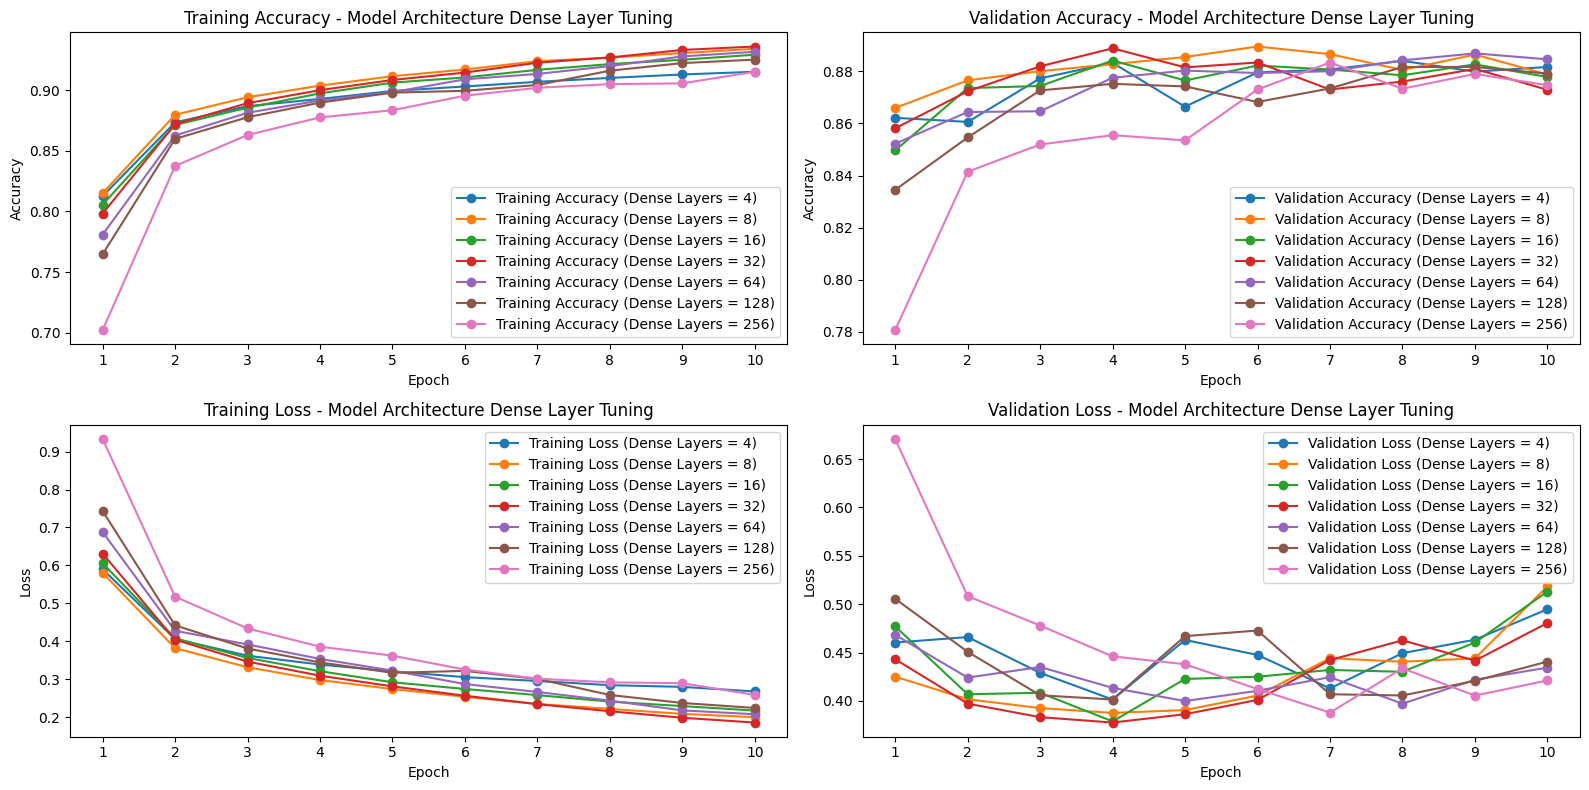

In [120]:
histories = [historyBatch1, historyBatch2, historyBatch3, historyDense3, historyBatch4, historyBatch5, historyBatch6]
title = 'Model Architecture Dense Layer Tuning'
hyperparam_name = 'Dense Layers'
hyperparam_values = [4, 8, 16, 32, 64, 128, 256]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

Correction: should be batch size tuning instead of dense layers tuning

In [16]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch2 = model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [18]:
historyBatch2 = modelBatch2.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10


I0000 00:00:1707667415.159103     152 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8550/8550 [==============================] - 41s 4ms/step - loss: 0.6508 - accuracy: 0.7952 - val_loss: 0.5347 - val_accuracy: 0.8327
Epoch 2/10
8550/8550 [==============================] - 37s 4ms/step - loss: 0.4582 - accuracy: 0.8564 - val_loss: 0.5032 - val_accuracy: 0.8551
Epoch 3/10
8550/8550 [==============================] - 36s 4ms/step - loss: 0.3841 - accuracy: 0.8789 - val_loss: 0.4963 - val_accuracy: 0.8555
Epoch 4/10
8550/8550 [==============================] - 36s 4ms/step - loss: 0.3356 - accuracy: 0.8931 - val_loss: 0.5180 - val_accuracy: 0.8584
Epoch 5/10
8550/8550 [==============================] - 36s 4ms/step - loss: 0.2952 - accuracy: 0.9082 - val_loss: 0.5711 - val_accuracy: 0.8576
Epoch 6/10
8550/8550 [==============================] - 36s 4ms/step - loss: 0.2659 - accuracy: 0.9161 - val_loss: 0.5972 - val_accuracy: 0.8577
Epoch 7/10
8550/8550 [==============================] - 36s 4ms/step - loss: 0.2425 - accuracy: 0.9240 - val_loss: 0.6771 - val_accuracy: 0.8

In [33]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch2 = model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_29 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 1600)            

In [38]:
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Nadam

def tune_optimizer(model, optimizer):
    """
    Tune the optimizer of the given model.
    
    Arguments:
    model: Keras model object.
    optimizer: String specifying the optimizer to use. Options: 'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta'.
    
    Returns:
    model: Updated Keras model with the specified optimizer.
    """
    if optimizer.lower() == 'adam':
        opt = Adam()
    elif optimizer.lower() == 'sgd':
        opt = SGD()
    elif optimizer.lower() == 'rmsprop':
        opt = RMSprop()
    elif optimizer.lower() == 'adagrad':
        opt = Adagrad()
    elif optimizer.lower() == 'adadelta':
        opt = Adadelta()
    elif optimizer.lower() == 'nadam':
        opt = Nadam()
#     elif optimizer.lower() == 'adamax':
#         opt = AdaMax()
    else:
        raise ValueError("Invalid optimizer. Choose from 'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta'.")
    
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model


In [42]:
modelOptimiser1 = tune_optimizer(modelBatch2, 'sgd')

In [43]:
modelOptimiser2 = tune_optimizer(modelBatch2, 'rmsprop')

In [44]:
modelOptimiser3 = tune_optimizer(modelBatch2, 'adagrad')

In [45]:
modelOptimiser4 = tune_optimizer(modelBatch2, 'adadelta')

In [46]:
modelOptimiser5 = tune_optimizer(modelBatch2, 'nadam')

In [47]:
historyOptimiser1 = modelOptimiser1.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.5896 - accuracy: 0.8107 - val_loss: 0.4369 - val_accuracy: 0.8601
Epoch 2/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3898 - accuracy: 0.8771 - val_loss: 0.3829 - val_accuracy: 0.8796
Epoch 3/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3388 - accuracy: 0.8932 - val_loss: 0.3967 - val_accuracy: 0.8774
Epoch 4/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.3081 - accuracy: 0.9018 - val_loss: 0.3823 - val_accuracy: 0.8824
Epoch 5/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.2838 - accuracy: 0.9087 - val_loss: 0.3825 - val_accuracy: 0.8836
Epoch 6/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.2646 - accuracy: 0.9143 - val_loss: 0.4247 - val_accuracy: 0.8830
Epoch 7/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.2478 - accuracy: 0.9199 - val_loss: 0.4111 - val_ac

In [48]:
historyOptimiser2 = modelOptimiser2.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.2060 - accuracy: 0.9326 - val_loss: 0.4608 - val_accuracy: 0.8820
Epoch 2/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1976 - accuracy: 0.9355 - val_loss: 0.5166 - val_accuracy: 0.8796
Epoch 3/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1898 - accuracy: 0.9376 - val_loss: 0.5029 - val_accuracy: 0.8826
Epoch 4/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1853 - accuracy: 0.9400 - val_loss: 0.5526 - val_accuracy: 0.8792
Epoch 5/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1767 - accuracy: 0.9431 - val_loss: 0.5155 - val_accuracy: 0.8826
Epoch 6/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1753 - accuracy: 0.9434 - val_loss: 0.5872 - val_accuracy: 0.8767
Epoch 7/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1687 - accuracy: 0.9453 - val_loss: 0.5339 - val_ac

In [49]:
historyOptimiser3 = modelOptimiser3.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1510 - accuracy: 0.9515 - val_loss: 0.7037 - val_accuracy: 0.8715
Epoch 2/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.1477 - accuracy: 0.9520 - val_loss: 0.6595 - val_accuracy: 0.8758
Epoch 3/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.1464 - accuracy: 0.9544 - val_loss: 0.6783 - val_accuracy: 0.8711
Epoch 4/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.1398 - accuracy: 0.9564 - val_loss: 0.6775 - val_accuracy: 0.8773
Epoch 5/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1367 - accuracy: 0.9563 - val_loss: 0.7264 - val_accuracy: 0.8727
Epoch 6/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1381 - accuracy: 0.9567 - val_loss: 0.6687 - val_accuracy: 0.8715
Epoch 7/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1306 - accuracy: 0.9597 - val_loss: 0.6925 - val_ac

In [50]:
historyOptimiser4 = modelOptimiser4.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1267 - accuracy: 0.9622 - val_loss: 0.6734 - val_accuracy: 0.8712
Epoch 2/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1169 - accuracy: 0.9640 - val_loss: 0.7889 - val_accuracy: 0.8721
Epoch 3/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1177 - accuracy: 0.9644 - val_loss: 0.9037 - val_accuracy: 0.8698
Epoch 4/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1146 - accuracy: 0.9659 - val_loss: 0.8567 - val_accuracy: 0.8718
Epoch 5/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1142 - accuracy: 0.9660 - val_loss: 0.9874 - val_accuracy: 0.8717
Epoch 6/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1146 - accuracy: 0.9669 - val_loss: 0.8050 - val_accuracy: 0.8722
Epoch 7/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1124 - accuracy: 0.9669 - val_loss: 0.8193 - val_ac

In [51]:
historyOptimiser5 = modelOptimiser5.fit(
    np.array(x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1051 - accuracy: 0.9696 - val_loss: 0.8939 - val_accuracy: 0.8743
Epoch 2/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.0998 - accuracy: 0.9710 - val_loss: 0.9753 - val_accuracy: 0.8680
Epoch 3/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1045 - accuracy: 0.9699 - val_loss: 1.0008 - val_accuracy: 0.8744
Epoch 4/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.0977 - accuracy: 0.9719 - val_loss: 0.9191 - val_accuracy: 0.8744
Epoch 5/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.1011 - accuracy: 0.9717 - val_loss: 1.0020 - val_accuracy: 0.8730
Epoch 6/10
8550/8550 [==============================] - 41s 5ms/step - loss: 0.0968 - accuracy: 0.9719 - val_loss: 0.9900 - val_accuracy: 0.8715
Epoch 7/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.0922 - accuracy: 0.9731 - val_loss: 0.9689 - val_ac

In [ ]:
# import cv2

# # Resize images to the desired shape (64x64 pixels)
# resized_x_train = [cv2.resize(image, (64, 64)) for image in x_train]
# resized_x_test = [cv2.resize(image, (64, 64)) for image in x_test]

# # Reshape images to add the channel dimension (1 for grayscale)
# resized_x_train = np.array(resized_x_train).reshape(-1, 64, 64, 1)
# resized_x_test = np.array(resized_x_test).reshape(-1, 64, 64, 1)

# # Now you can use resized_x_train and resized_x_test as input to your model


### Tuning Dropout Layer

In [ ]:
def modelDropout()
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch2 = model

In [15]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))

# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch2 = model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [21]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput1 = model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                 

In [33]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput2 = model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                 

In [35]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(256, (3,3), activation="relu"))
#model.add(Conv2D(256, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))


# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput3 = model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_29 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [38]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput4 = model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_36 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_38 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [39]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput5 = model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_41 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [40]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput6 = model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_46 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_48 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [46]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput7 = model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_51 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_53 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [47]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput8 = model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_56 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_58 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [48]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput9 = model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_61 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_63 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [18]:
historyBatch2 = modelBatch2.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 37s 4ms/step - loss: 0.5824 - accuracy: 0.8164 - val_loss: 0.5277 - val_accuracy: 0.8414
Epoch 2/10
8550/8550 [==============================] - 37s 4ms/step - loss: 0.4432 - accuracy: 0.8616 - val_loss: 0.5714 - val_accuracy: 0.8475
Epoch 3/10
8550/8550 [==============================] - 36s 4ms/step - loss: 0.3724 - accuracy: 0.8838 - val_loss: 0.5420 - val_accuracy: 0.8556
Epoch 4/10
8550/8550 [==============================] - 37s 4ms/step - loss: 0.3234 - accuracy: 0.8988 - val_loss: 0.5155 - val_accuracy: 0.8554
Epoch 5/10
8550/8550 [==============================] - 36s 4ms/step - loss: 0.2887 - accuracy: 0.9098 - val_loss: 0.5620 - val_accuracy: 0.8554
Epoch 6/10
8550/8550 [==============================] - 37s 4ms/step - loss: 0.2602 - accuracy: 0.9198 - val_loss: 0.6191 - val_accuracy: 0.8577
Epoch 7/10
8550/8550 [==============================] - 37s 4ms/step - loss: 0.2355 - accuracy: 0.9269 - val_loss: 0.7171 - val_ac

In [22]:
historyInput1 = modelInput1.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.6172 - accuracy: 0.8047 - val_loss: 0.5014 - val_accuracy: 0.8443
Epoch 2/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.4163 - accuracy: 0.8709 - val_loss: 0.4276 - val_accuracy: 0.8656
Epoch 3/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3664 - accuracy: 0.8857 - val_loss: 0.4383 - val_accuracy: 0.8727
Epoch 4/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3406 - accuracy: 0.8919 - val_loss: 0.4386 - val_accuracy: 0.8735
Epoch 5/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3225 - accuracy: 0.8977 - val_loss: 0.4314 - val_accuracy: 0.8749
Epoch 6/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3099 - accuracy: 0.9020 - val_loss: 0.4115 - val_accuracy: 0.8798
Epoch 7/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.2890 - accuracy: 0.9086 - val_loss: 0.4523 - val_ac

In [36]:
historyInput2 = modelInput2.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 49s 5ms/step - loss: 0.6606 - accuracy: 0.7895 - val_loss: 0.4791 - val_accuracy: 0.8501
Epoch 2/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.4464 - accuracy: 0.8607 - val_loss: 0.4324 - val_accuracy: 0.8671
Epoch 3/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.4065 - accuracy: 0.8729 - val_loss: 0.4389 - val_accuracy: 0.8669
Epoch 4/10
8550/8550 [==============================] - 45s 5ms/step - loss: 0.3801 - accuracy: 0.8829 - val_loss: 0.4191 - val_accuracy: 0.8689
Epoch 5/10
8550/8550 [==============================] - 45s 5ms/step - loss: 0.3662 - accuracy: 0.8855 - val_loss: 0.5001 - val_accuracy: 0.8689
Epoch 6/10
8550/8550 [==============================] - 45s 5ms/step - loss: 0.3495 - accuracy: 0.8911 - val_loss: 0.4987 - val_accuracy: 0.8691
Epoch 7/10
8550/8550 [==============================] - 45s 5ms/step - loss: 0.3427 - accuracy: 0.8916 - val_loss: 0.4822 - val_ac

In [37]:
historyInput3 = modelInput3.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 52s 6ms/step - loss: 0.7139 - accuracy: 0.7698 - val_loss: 0.5428 - val_accuracy: 0.8271
Epoch 2/10
8550/8550 [==============================] - 48s 6ms/step - loss: 0.4593 - accuracy: 0.8589 - val_loss: 0.4481 - val_accuracy: 0.8637
Epoch 3/10
8550/8550 [==============================] - 48s 6ms/step - loss: 0.4130 - accuracy: 0.8721 - val_loss: 0.4577 - val_accuracy: 0.8681
Epoch 4/10
8550/8550 [==============================] - 48s 6ms/step - loss: 0.3872 - accuracy: 0.8798 - val_loss: 0.4516 - val_accuracy: 0.8658
Epoch 5/10
8550/8550 [==============================] - 48s 6ms/step - loss: 0.3744 - accuracy: 0.8843 - val_loss: 0.4597 - val_accuracy: 0.8661
Epoch 6/10
8550/8550 [==============================] - 48s 6ms/step - loss: 0.3603 - accuracy: 0.8902 - val_loss: 0.5145 - val_accuracy: 0.8673
Epoch 7/10
8550/8550 [==============================] - 49s 6ms/step - loss: 0.3524 - accuracy: 0.8915 - val_loss: 0.4656 - val_ac

In [41]:
historyInput4 = modelInput4.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 45s 5ms/step - loss: 0.6222 - accuracy: 0.8030 - val_loss: 0.4629 - val_accuracy: 0.8530
Epoch 2/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.4177 - accuracy: 0.8696 - val_loss: 0.4485 - val_accuracy: 0.8625
Epoch 3/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3686 - accuracy: 0.8842 - val_loss: 0.3976 - val_accuracy: 0.8800
Epoch 4/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3428 - accuracy: 0.8935 - val_loss: 0.4225 - val_accuracy: 0.8729
Epoch 5/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3247 - accuracy: 0.8987 - val_loss: 0.4562 - val_accuracy: 0.8687
Epoch 6/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3075 - accuracy: 0.9028 - val_loss: 0.4259 - val_accuracy: 0.8729
Epoch 7/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.2959 - accuracy: 0.9062 - val_loss: 0.4302 - val_ac

In [42]:
historyInput5 = modelInput5.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 45s 5ms/step - loss: 0.6133 - accuracy: 0.8055 - val_loss: 0.4624 - val_accuracy: 0.8534
Epoch 2/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.4107 - accuracy: 0.8723 - val_loss: 0.4140 - val_accuracy: 0.8704
Epoch 3/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3632 - accuracy: 0.8861 - val_loss: 0.3924 - val_accuracy: 0.8791
Epoch 4/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3399 - accuracy: 0.8936 - val_loss: 0.4345 - val_accuracy: 0.8741
Epoch 5/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3186 - accuracy: 0.9007 - val_loss: 0.4202 - val_accuracy: 0.8751
Epoch 6/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3002 - accuracy: 0.9057 - val_loss: 0.4251 - val_accuracy: 0.8763
Epoch 7/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.2876 - accuracy: 0.9087 - val_loss: 0.4590 - val_ac

In [43]:
historyInput6 = modelInput6.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.6045 - accuracy: 0.8083 - val_loss: 0.4618 - val_accuracy: 0.8591
Epoch 2/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.4050 - accuracy: 0.8735 - val_loss: 0.4430 - val_accuracy: 0.8615
Epoch 3/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3603 - accuracy: 0.8866 - val_loss: 0.3853 - val_accuracy: 0.8819
Epoch 4/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3318 - accuracy: 0.8965 - val_loss: 0.4906 - val_accuracy: 0.8566
Epoch 5/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.3117 - accuracy: 0.9027 - val_loss: 0.4236 - val_accuracy: 0.8801
Epoch 6/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.2997 - accuracy: 0.9061 - val_loss: 0.4316 - val_accuracy: 0.8764
Epoch 7/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.2950 - accuracy: 0.9069 - val_loss: 0.4243 - val_ac

In [49]:
historyInput7 = modelInput7.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.6077 - accuracy: 0.8104 - val_loss: 0.4787 - val_accuracy: 0.8539
Epoch 2/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.4106 - accuracy: 0.8715 - val_loss: 0.4526 - val_accuracy: 0.8627
Epoch 3/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3675 - accuracy: 0.8855 - val_loss: 0.4169 - val_accuracy: 0.8752
Epoch 4/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3391 - accuracy: 0.8925 - val_loss: 0.4399 - val_accuracy: 0.8788
Epoch 5/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3201 - accuracy: 0.8978 - val_loss: 0.4438 - val_accuracy: 0.8746
Epoch 6/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3026 - accuracy: 0.9052 - val_loss: 0.4128 - val_accuracy: 0.8770
Epoch 7/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.2840 - accuracy: 0.9102 - val_loss: 0.4678 - val_ac

In [50]:
historyInput8 = modelInput8.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 45s 5ms/step - loss: 0.6149 - accuracy: 0.8061 - val_loss: 0.4687 - val_accuracy: 0.8579
Epoch 2/10
8550/8550 [==============================] - 43s 5ms/step - loss: 0.4126 - accuracy: 0.8730 - val_loss: 0.4564 - val_accuracy: 0.8631
Epoch 3/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3613 - accuracy: 0.8873 - val_loss: 0.4766 - val_accuracy: 0.8628
Epoch 4/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3354 - accuracy: 0.8953 - val_loss: 0.4454 - val_accuracy: 0.8658
Epoch 5/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.3111 - accuracy: 0.9028 - val_loss: 0.4687 - val_accuracy: 0.8590
Epoch 6/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.2966 - accuracy: 0.9069 - val_loss: 0.5088 - val_accuracy: 0.8704
Epoch 7/10
8550/8550 [==============================] - 42s 5ms/step - loss: 0.2827 - accuracy: 0.9109 - val_loss: 0.5424 - val_ac

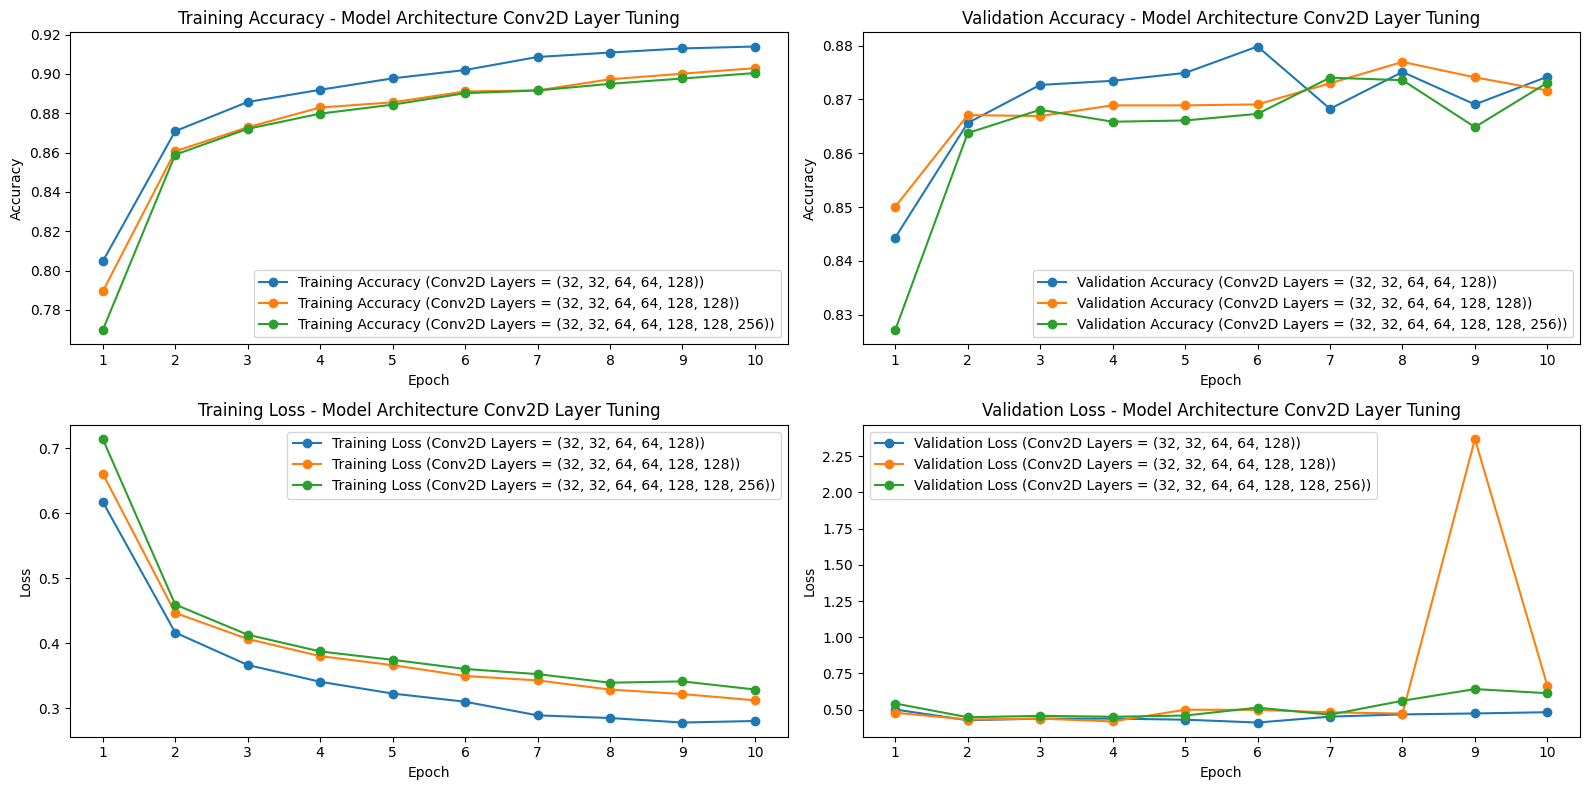

In [45]:
histories = [historyInput1, historyInput2, historyInput3]
title = 'Model Architecture Conv2D Layer Tuning'
hyperparam_name = 'Conv2D Layers'
hyperparam_values = [(32,32,64,64,128), (32,32,64,64,128,128), (32,32,64,64,128,128,256)]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

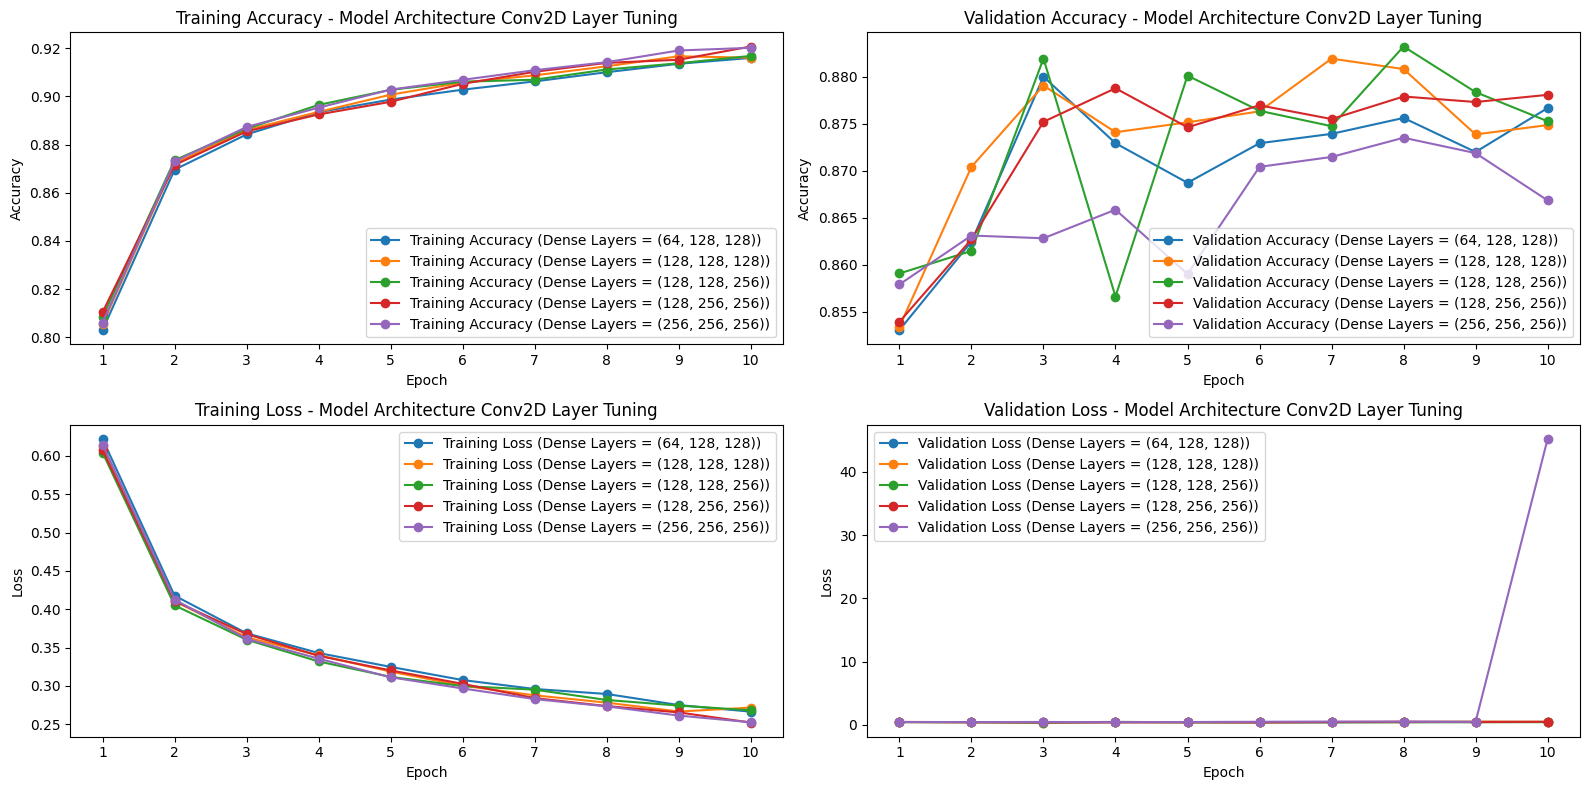

In [52]:
histories = [historyInput4, historyInput5, historyInput6,historyInput7,historyInput8]
title = 'Model Architecture Conv2D Layer Tuning'
hyperparam_name = 'Dense Layers'
hyperparam_values = [(64,128,128),(128,128,128), (128,128,256),(128,256,256),(256,256,256)]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

### Batch Size

In [53]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch1 = model

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_66 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_67 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_68 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [54]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch2 = model

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_71 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_73 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [55]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch3 = model

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_76 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_77 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_78 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [56]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch4 = model

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_81 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_82 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_83 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [57]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelBatch5 = model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_86 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_87 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_88 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [58]:
historyBatch1 = modelBatch1.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=4,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
17100/17100 [==============================] - 84s 5ms/step - loss: 0.7708 - accuracy: 0.7609 - val_loss: 0.6839 - val_accuracy: 0.7949
Epoch 2/10
17100/17100 [==============================] - 81s 5ms/step - loss: 0.6544 - accuracy: 0.8091 - val_loss: 0.5901 - val_accuracy: 0.8273
Epoch 3/10
17100/17100 [==============================] - 82s 5ms/step - loss: 0.6283 - accuracy: 0.8189 - val_loss: 0.6670 - val_accuracy: 0.8170
Epoch 4/10
17100/17100 [==============================] - 82s 5ms/step - loss: 0.6428 - accuracy: 0.8207 - val_loss: 0.6113 - val_accuracy: 0.8184
Epoch 5/10
17100/17100 [==============================] - 81s 5ms/step - loss: 0.7806 - accuracy: 0.7750 - val_loss: 0.7604 - val_accuracy: 0.8182
Epoch 6/10
17100/17100 [==============================] - 82s 5ms/step - loss: 0.7476 - accuracy: 0.7980 - val_loss: 0.6422 - val_accuracy: 0.8273
Epoch 7/10
17100/17100 [==============================] - 82s 5ms/step - loss: 0.7659 - accuracy: 0.7972 - val_loss: 0

In [59]:
historyBatch2 = modelBatch2.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=16,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
4275/4275 [==============================] - 27s 6ms/step - loss: 0.6840 - accuracy: 0.7875 - val_loss: 0.6938 - val_accuracy: 0.8226
Epoch 2/10
4275/4275 [==============================] - 24s 6ms/step - loss: 0.5421 - accuracy: 0.8389 - val_loss: 0.6477 - val_accuracy: 0.8306
Epoch 3/10
4275/4275 [==============================] - 24s 6ms/step - loss: 0.5220 - accuracy: 0.8487 - val_loss: 0.6227 - val_accuracy: 0.8496
Epoch 4/10
4275/4275 [==============================] - 24s 6ms/step - loss: 0.4861 - accuracy: 0.8606 - val_loss: 0.7389 - val_accuracy: 0.8542
Epoch 5/10
4275/4275 [==============================] - 24s 6ms/step - loss: 0.4822 - accuracy: 0.8623 - val_loss: 8.1572 - val_accuracy: 0.8502
Epoch 6/10
4275/4275 [==============================] - 23s 5ms/step - loss: 0.4735 - accuracy: 0.8665 - val_loss: 4.3147 - val_accuracy: 0.8532
Epoch 7/10
4275/4275 [==============================] - 23s 5ms/step - loss: 0.4836 - accuracy: 0.8686 - val_loss: 8.5957 - val_ac

In [60]:
historyBatch3 = modelBatch3.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 20s 8ms/step - loss: 0.6561 - accuracy: 0.7929 - val_loss: 0.5584 - val_accuracy: 0.8391
Epoch 2/10
2138/2138 [==============================] - 16s 8ms/step - loss: 0.4762 - accuracy: 0.8527 - val_loss: 0.5101 - val_accuracy: 0.8531
Epoch 3/10
2138/2138 [==============================] - 16s 8ms/step - loss: 0.4821 - accuracy: 0.8570 - val_loss: 0.5620 - val_accuracy: 0.8570
Epoch 4/10
2138/2138 [==============================] - 16s 8ms/step - loss: 0.4238 - accuracy: 0.8735 - val_loss: 0.5985 - val_accuracy: 0.8560
Epoch 5/10
2138/2138 [==============================] - 16s 8ms/step - loss: 0.4133 - accuracy: 0.8780 - val_loss: 0.5151 - val_accuracy: 0.8581
Epoch 6/10
2138/2138 [==============================] - 16s 8ms/step - loss: 0.4033 - accuracy: 0.8823 - val_loss: 0.5422 - val_accuracy: 0.8688
Epoch 7/10
2138/2138 [==============================] - 16s 8ms/step - loss: 0.3966 - accuracy: 0.8862 - val_loss: 0.6299 - val_ac

In [61]:
historyBatch4 = modelBatch4.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=64,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
1069/1069 [==============================] - 16s 12ms/step - loss: 0.6554 - accuracy: 0.7939 - val_loss: 0.5361 - val_accuracy: 0.8407
Epoch 2/10
1069/1069 [==============================] - 12s 11ms/step - loss: 1.6002 - accuracy: 0.4391 - val_loss: 2.6301 - val_accuracy: 0.0835
Epoch 3/10
1069/1069 [==============================] - 12s 11ms/step - loss: 2.4851 - accuracy: 0.0826 - val_loss: 2.6299 - val_accuracy: 0.0835
Epoch 4/10
1069/1069 [==============================] - 12s 11ms/step - loss: 2.4850 - accuracy: 0.0821 - val_loss: 2.6302 - val_accuracy: 0.0824
Epoch 5/10
1069/1069 [==============================] - 12s 11ms/step - loss: 2.4850 - accuracy: 0.0815 - val_loss: 2.6299 - val_accuracy: 0.0816
Epoch 6/10
1069/1069 [==============================] - 12s 11ms/step - loss: 2.4850 - accuracy: 0.0832 - val_loss: 2.6301 - val_accuracy: 0.0816
Epoch 7/10
1069/1069 [==============================] - 12s 11ms/step - loss: 2.4850 - accuracy: 0.0834 - val_loss: 2.6301 -

In [62]:
historyBatch5 = modelBatch5.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=128,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
535/535 [==============================] - 15s 20ms/step - loss: 0.7227 - accuracy: 0.7720 - val_loss: 1.3171 - val_accuracy: 0.7003
Epoch 2/10
535/535 [==============================] - 10s 18ms/step - loss: 0.5402 - accuracy: 0.8407 - val_loss: 0.6046 - val_accuracy: 0.8511
Epoch 3/10
535/535 [==============================] - 10s 18ms/step - loss: 0.5878 - accuracy: 0.8564 - val_loss: 0.7188 - val_accuracy: 0.8358
Epoch 4/10
535/535 [==============================] - 10s 18ms/step - loss: 0.4856 - accuracy: 0.8641 - val_loss: 0.7200 - val_accuracy: 0.8240
Epoch 5/10
535/535 [==============================] - 10s 18ms/step - loss: 0.5709 - accuracy: 0.8569 - val_loss: 0.6226 - val_accuracy: 0.8570
Epoch 6/10
535/535 [==============================] - 10s 18ms/step - loss: 0.5212 - accuracy: 0.8552 - val_loss: 0.6207 - val_accuracy: 0.8273
Epoch 7/10
535/535 [==============================] - 10s 18ms/step - loss: 0.4974 - accuracy: 0.8481 - val_loss: 0.7528 - val_accuracy:

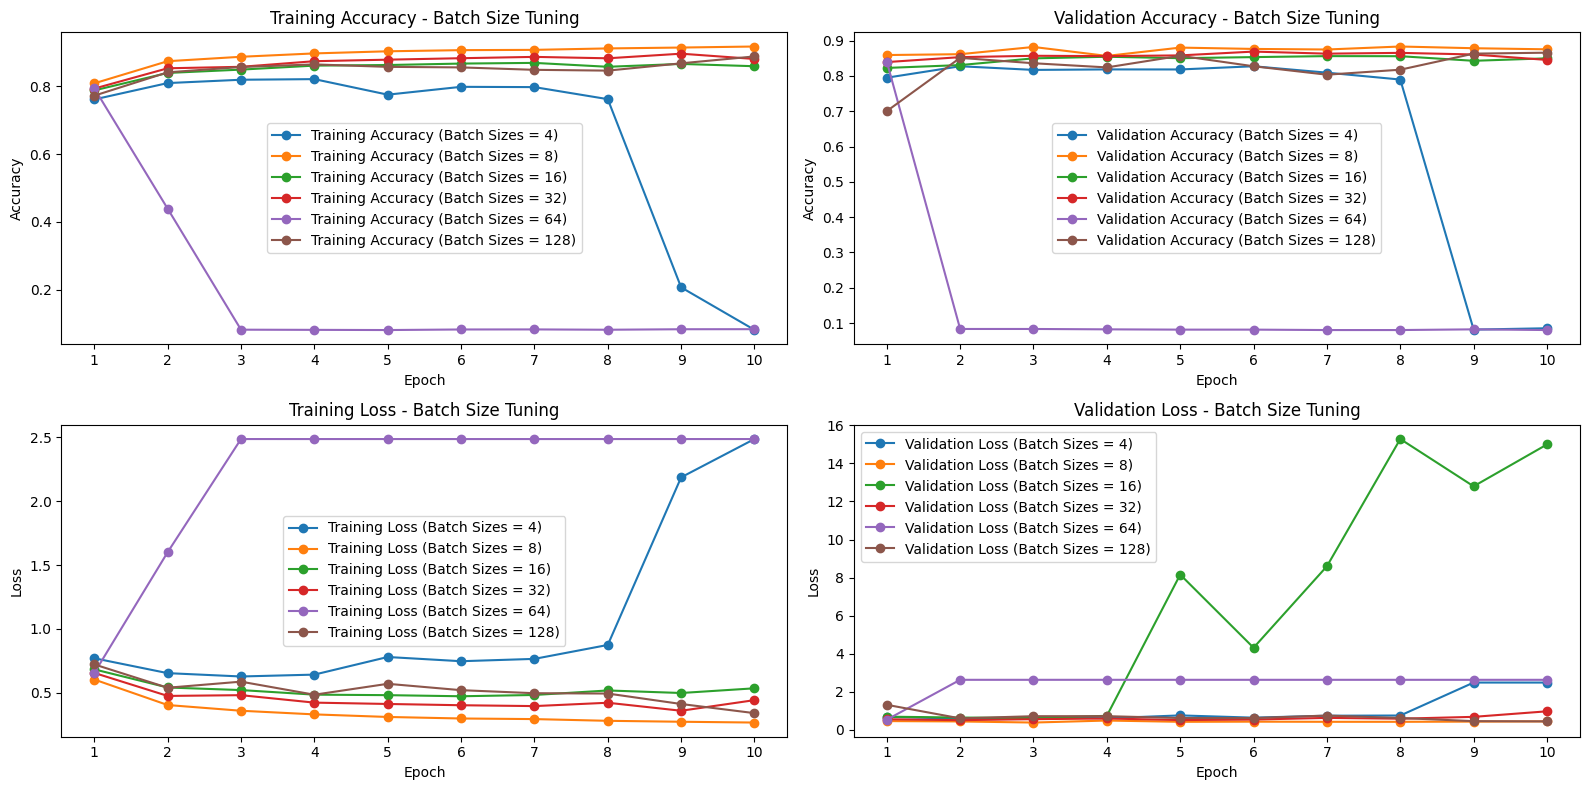

In [66]:
histories = [historyBatch1,historyInput6, historyBatch2, historyBatch3,historyBatch4,historyBatch5]
title = 'Batch Size Tuning'
hyperparam_name = 'Batch Sizes'
hyperparam_values = [4,8,16,32,64,128]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SpatialDropout2D

def create_convnet(dropout_rate):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
    model.add(Conv2D(32, (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(SpatialDropout2D(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(N_CATEGORIES, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [69]:
modelDropout1 = create_convnet(dropout_rate=0.2)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_91 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_92 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_93 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [70]:
modelDropout2 = create_convnet(dropout_rate=0.3)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_96 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_97 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_98 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [71]:
modelDropout3 = create_convnet(dropout_rate=0.4)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 62, 62, 32)        320       
                                                                 
 conv2d_101 (Conv2D)         (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_102 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 conv2d_103 (Conv2D)         (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [72]:
modelDropout4 = create_convnet(dropout_rate=0.5)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 62, 62, 32)        320       
                                                                 
 conv2d_106 (Conv2D)         (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_107 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 conv2d_108 (Conv2D)         (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                               

In [74]:
historyDropout1 = modelDropout1.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=64,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10


2024-02-12 16:48:07.817334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1069/1069 [==============================] - 18s 14ms/step - loss: 0.7190 - accuracy: 0.7733 - val_loss: 0.5258 - val_accuracy: 0.8397
Epoch 2/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.5099 - accuracy: 0.8403 - val_loss: 0.4933 - val_accuracy: 0.8481
Epoch 3/10
1069/1069 [==============================] - 14s 14ms/step - loss: 0.4542 - accuracy: 0.8579 - val_loss: 0.5091 - val_accuracy: 0.8676
Epoch 4/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.4237 - accuracy: 0.8684 - val_loss: 0.5137 - val_accuracy: 0.8671
Epoch 5/10
1069/1069 [==============================] - 14s 14ms/step - loss: 0.4118 - accuracy: 0.8714 - val_loss: 0.5732 - val_accuracy: 0.8592
Epoch 6/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.3963 - accuracy: 0.8787 - val_loss: 0.6922 - val_accuracy: 0.8580
Epoch 7/10
1069/1069 [==============================] - 14s 13ms/step - loss: 0.3863 - accuracy: 0.8818 - val_loss: 0.5789 - val_accura

In [75]:
historyDropout2 = modelDropout2.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=64,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10


2024-02-12 16:50:40.849568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/spatial_dropout2d_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1069/1069 [==============================] - 17s 14ms/step - loss: 0.7258 - accuracy: 0.7721 - val_loss: 0.5498 - val_accuracy: 0.8371
Epoch 2/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.5028 - accuracy: 0.8430 - val_loss: 0.5249 - val_accuracy: 0.8613
Epoch 3/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.4563 - accuracy: 0.8591 - val_loss: 0.4535 - val_accuracy: 0.8650
Epoch 4/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.4298 - accuracy: 0.8667 - val_loss: 0.4762 - val_accuracy: 0.8618
Epoch 5/10
1069/1069 [==============================] - 14s 14ms/step - loss: 0.4133 - accuracy: 0.8725 - val_loss: 0.4781 - val_accuracy: 0.8701
Epoch 6/10
1069/1069 [==============================] - 14s 14ms/step - loss: 0.4001 - accuracy: 0.8778 - val_loss: 0.4694 - val_accuracy: 0.8737
Epoch 7/10
1069/1069 [==============================] - 14s 14ms/step - loss: 0.3835 - accuracy: 0.8823 - val_loss: 0.4552 - val_accura

In [76]:
historyDropout3 = modelDropout3.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=64,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10


2024-02-12 16:53:13.201102: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/spatial_dropout2d_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1069/1069 [==============================] - 18s 14ms/step - loss: 0.7443 - accuracy: 0.7646 - val_loss: 0.5000 - val_accuracy: 0.8442
Epoch 2/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.5298 - accuracy: 0.8360 - val_loss: 0.5067 - val_accuracy: 0.8564
Epoch 3/10
1069/1069 [==============================] - 14s 14ms/step - loss: 0.4727 - accuracy: 0.8530 - val_loss: 0.4996 - val_accuracy: 0.8607
Epoch 4/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.4494 - accuracy: 0.8607 - val_loss: 0.5481 - val_accuracy: 0.8642
Epoch 5/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.4346 - accuracy: 0.8660 - val_loss: 0.5637 - val_accuracy: 0.8536
Epoch 6/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.4243 - accuracy: 0.8713 - val_loss: 0.4870 - val_accuracy: 0.8689
Epoch 7/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.4094 - accuracy: 0.8757 - val_loss: 0.5781 - val_accura

In [77]:
historyDropout4 = modelDropout4.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=64,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10


2024-02-12 16:56:40.709997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/spatial_dropout2d_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1069/1069 [==============================] - 18s 15ms/step - loss: 0.7877 - accuracy: 0.7491 - val_loss: 0.5295 - val_accuracy: 0.8334
Epoch 2/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.5870 - accuracy: 0.8186 - val_loss: 0.5363 - val_accuracy: 0.8467
Epoch 3/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.5364 - accuracy: 0.8358 - val_loss: 0.6014 - val_accuracy: 0.8403
Epoch 4/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.5057 - accuracy: 0.8454 - val_loss: 0.5255 - val_accuracy: 0.8591
Epoch 5/10
1069/1069 [==============================] - 14s 14ms/step - loss: 0.4919 - accuracy: 0.8504 - val_loss: 0.5334 - val_accuracy: 0.8642
Epoch 6/10
1069/1069 [==============================] - 14s 14ms/step - loss: 0.4755 - accuracy: 0.8562 - val_loss: 0.6084 - val_accuracy: 0.8571
Epoch 7/10
1069/1069 [==============================] - 15s 14ms/step - loss: 0.4714 - accuracy: 0.8606 - val_loss: 0.4809 - val_accura

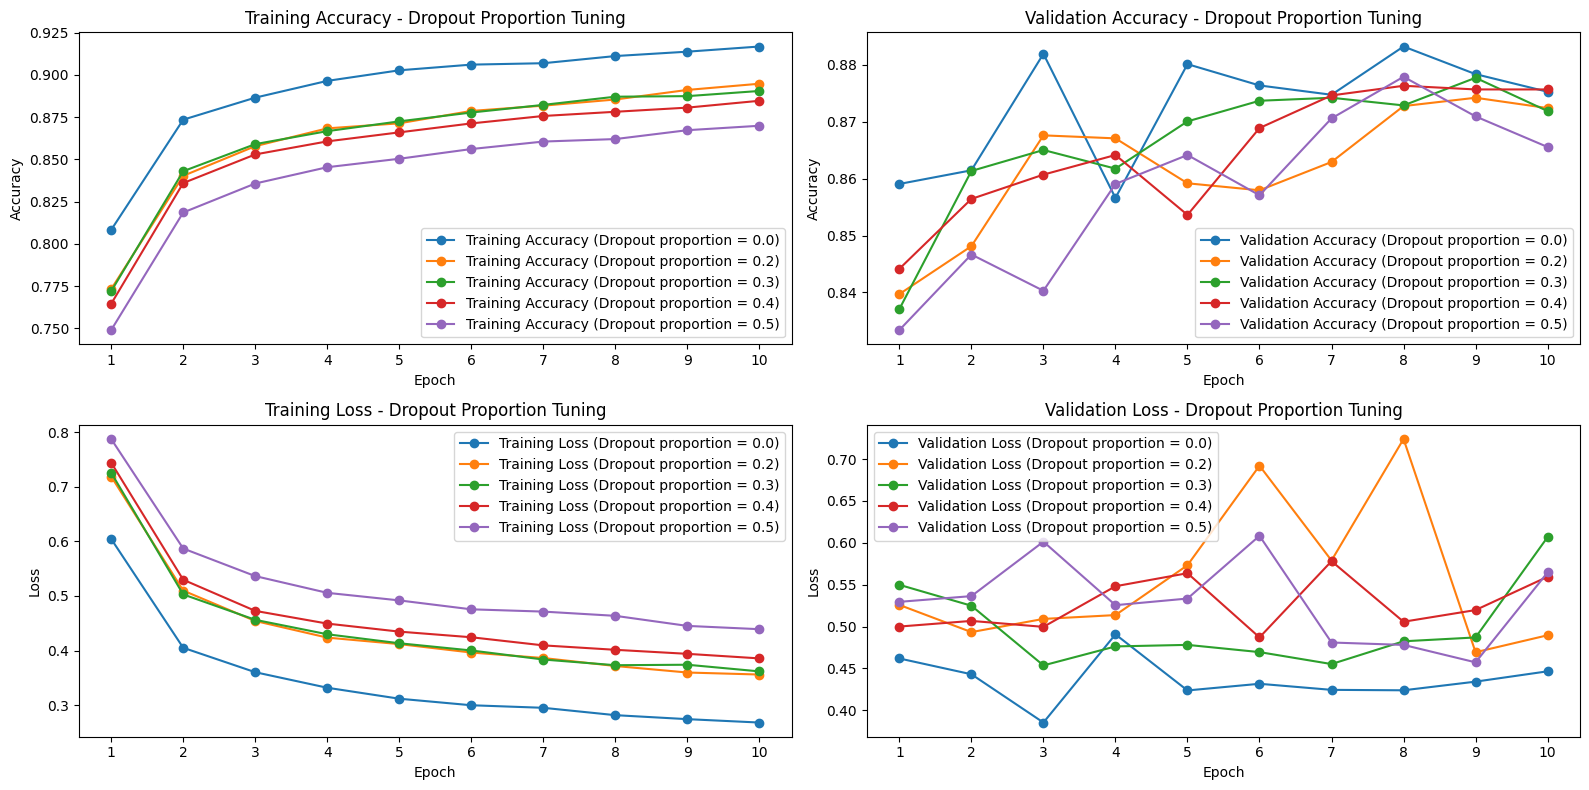

In [79]:
histories = [historyInput6,historyDropout1, historyDropout2, historyDropout3,historyDropout4]
title = 'Dropout Proportion Tuning'
hyperparam_name = 'Dropout proportion'
hyperparam_values = [0.0, 0.2, 0.3, 0.4, 0.5]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

### Tuning L2 Regularisation

In [35]:
pip install neptune-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 11.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
from tensorflow.keras.regularizers import l2

def create_convnet_with_l2(l2_penalty):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=l2(l2_penalty), input_shape=(64, 64, 1)))
    model.add(Conv2D(32, (3,3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(Dense(N_CATEGORIES, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [23]:
modelL2_1 = create_convnet_with_l2(0.0001)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [22]:
modelL2_2 = create_convnet_with_l2(0.0002)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                 

In [24]:
modelL2_3 = create_convnet_with_l2(0.0005)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [25]:
modelL2_4 = create_convnet_with_l2(0.001)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_28 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [28]:
modelL2_5 = create_convnet_with_l2(0.002)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_31 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [27]:
historyL2_1 = modelL2_1.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10


I0000 00:00:1707901445.995599     195 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8550/8550 [==============================] - 52s 5ms/step - loss: 0.6928 - accuracy: 0.8009 - val_loss: 0.5935 - val_accuracy: 0.8381
Epoch 2/10
8550/8550 [==============================] - 44s 5ms/step - loss: 0.5152 - accuracy: 0.8689 - val_loss: 0.5408 - val_accuracy: 0.8634
Epoch 3/10
8550/8550 [==============================] - 44s 5ms/step - loss: 0.4803 - accuracy: 0.8813 - val_loss: 0.5037 - val_accuracy: 0.8749
Epoch 4/10
8550/8550 [==============================] - 44s 5ms/step - loss: 0.4557 - accuracy: 0.8891 - val_loss: 0.5092 - val_accuracy: 0.8730
Epoch 5/10
8550/8550 [==============================] - 44s 5ms/step - loss: 0.4446 - accuracy: 0.8943 - val_loss: 0.4948 - val_accuracy: 0.8786
Epoch 6/10
8550/8550 [==============================] - 44s 5ms/step - loss: 0.4349 - accuracy: 0.8987 - val_loss: 0.5044 - val_accuracy: 0.8784
Epoch 7/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.4258 - accuracy: 0.9016 - val_loss: 0.5248 - val_accuracy: 0.8

In [29]:
historyL2_2 = modelL2_2.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 50s 6ms/step - loss: 0.7394 - accuracy: 0.8022 - val_loss: 0.6162 - val_accuracy: 0.8512
Epoch 2/10
8550/8550 [==============================] - 47s 5ms/step - loss: 0.5644 - accuracy: 0.8673 - val_loss: 0.5612 - val_accuracy: 0.8696
Epoch 3/10
8550/8550 [==============================] - 47s 5ms/step - loss: 0.5268 - accuracy: 0.8776 - val_loss: 0.5543 - val_accuracy: 0.8726
Epoch 4/10
8550/8550 [==============================] - 47s 5ms/step - loss: 0.5032 - accuracy: 0.8847 - val_loss: 0.5219 - val_accuracy: 0.8815
Epoch 5/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.4887 - accuracy: 0.8893 - val_loss: 0.5109 - val_accuracy: 0.8808
Epoch 6/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.4760 - accuracy: 0.8914 - val_loss: 0.5265 - val_accuracy: 0.8784
Epoch 7/10
8550/8550 [==============================] - 47s 5ms/step - loss: 0.4707 - accuracy: 0.8927 - val_loss: 0.5276 - val_ac

In [30]:
historyL2_3 = modelL2_3.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 50s 6ms/step - loss: 0.8898 - accuracy: 0.7437 - val_loss: 0.6846 - val_accuracy: 0.8236
Epoch 2/10
8550/8550 [==============================] - 47s 5ms/step - loss: 0.6316 - accuracy: 0.8386 - val_loss: 0.6841 - val_accuracy: 0.8294
Epoch 3/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.5850 - accuracy: 0.8551 - val_loss: 0.5774 - val_accuracy: 0.8575
Epoch 4/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.5589 - accuracy: 0.8640 - val_loss: 0.5754 - val_accuracy: 0.8619
Epoch 5/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.5419 - accuracy: 0.8692 - val_loss: 0.5384 - val_accuracy: 0.8706
Epoch 6/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.5285 - accuracy: 0.8740 - val_loss: 0.5436 - val_accuracy: 0.8701
Epoch 7/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.5190 - accuracy: 0.8761 - val_loss: 0.5322 - val_ac

In [31]:
historyL2_4 = modelL2_4.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 49s 5ms/step - loss: 0.9117 - accuracy: 0.7730 - val_loss: 0.6995 - val_accuracy: 0.8422
Epoch 2/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.6745 - accuracy: 0.8481 - val_loss: 0.6478 - val_accuracy: 0.8541
Epoch 3/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.6307 - accuracy: 0.8586 - val_loss: 0.6266 - val_accuracy: 0.8589
Epoch 4/10
8550/8550 [==============================] - 47s 5ms/step - loss: 0.6122 - accuracy: 0.8621 - val_loss: 0.6511 - val_accuracy: 0.8500
Epoch 5/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.5945 - accuracy: 0.8672 - val_loss: 0.6190 - val_accuracy: 0.8592
Epoch 6/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.5853 - accuracy: 0.8677 - val_loss: 0.5919 - val_accuracy: 0.8670
Epoch 7/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.5770 - accuracy: 0.8682 - val_loss: 0.5957 - val_ac

In [32]:
historyL2_5 = modelL2_5.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
8550/8550 [==============================] - 50s 6ms/step - loss: 0.9918 - accuracy: 0.7721 - val_loss: 0.8008 - val_accuracy: 0.8312
Epoch 2/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.7506 - accuracy: 0.8367 - val_loss: 0.7323 - val_accuracy: 0.8423
Epoch 3/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.7041 - accuracy: 0.8461 - val_loss: 0.6805 - val_accuracy: 0.8539
Epoch 4/10
8550/8550 [==============================] - 47s 5ms/step - loss: 0.6821 - accuracy: 0.8509 - val_loss: 0.6670 - val_accuracy: 0.8559
Epoch 5/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.6708 - accuracy: 0.8537 - val_loss: 0.6838 - val_accuracy: 0.8487
Epoch 6/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.6551 - accuracy: 0.8561 - val_loss: 0.6527 - val_accuracy: 0.8543
Epoch 7/10
8550/8550 [==============================] - 46s 5ms/step - loss: 0.6522 - accuracy: 0.8566 - val_loss: 0.6743 - val_ac

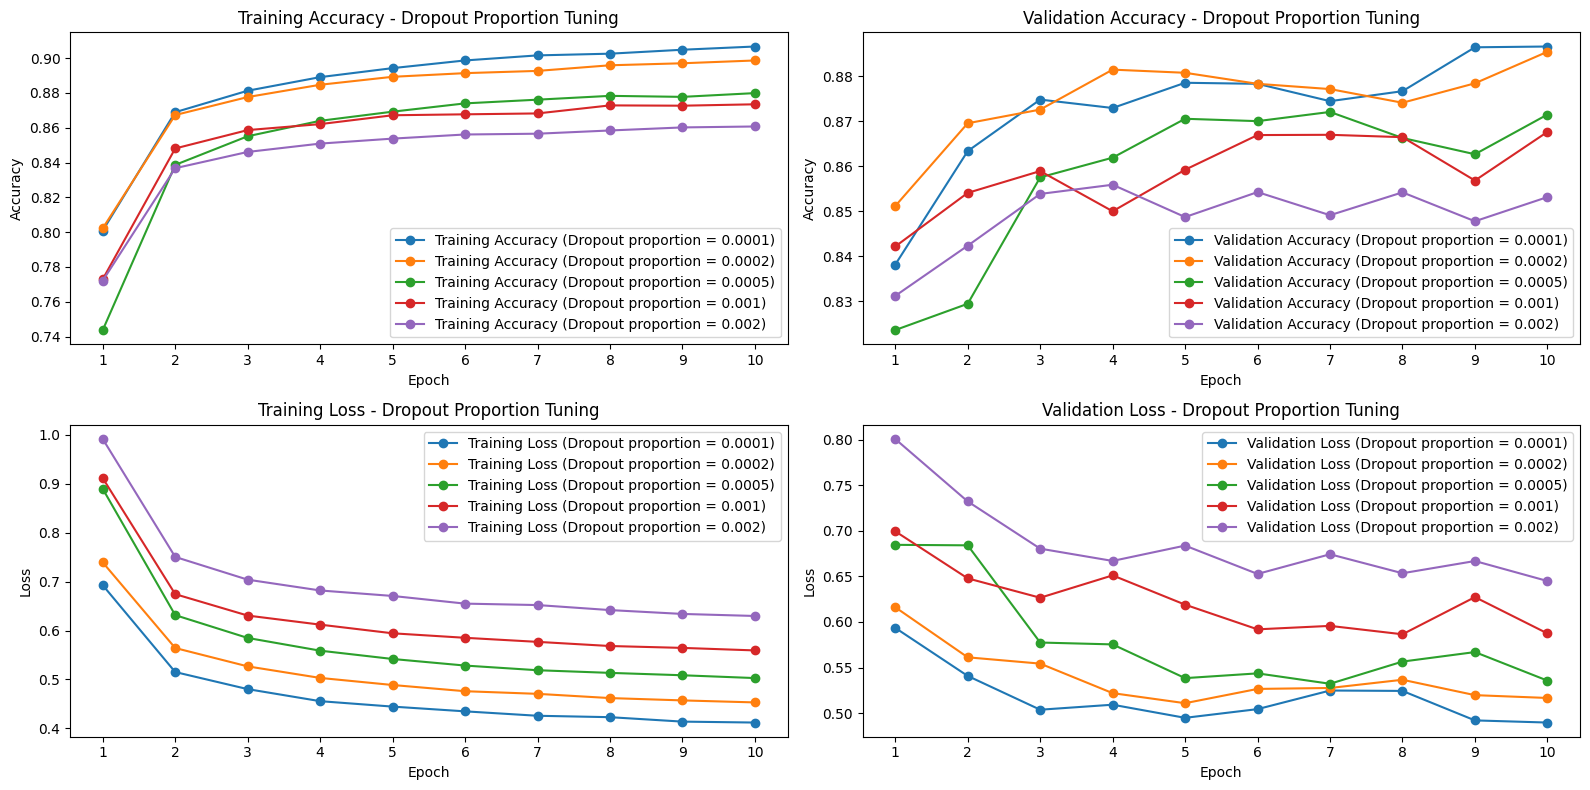

In [34]:
histories = [historyL2_1,historyL2_2, historyL2_3, historyL2_4,historyL2_5]
title = 'Dropout Proportion Tuning'
hyperparam_name = 'Dropout proportion'
hyperparam_values = [0.0001, 0.0002, 0.0005, 0.001, 0.002]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

In [28]:
from tensorflow.keras.regularizers import l2

def create_convnet_with_l2(l2_penalty):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=l2(l2_penalty), input_shape=(64, 64, 1)))
    model.add(Conv2D(32, (3,3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(Dense(N_CATEGORIES, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [29]:
modelL2_1 = create_convnet_with_l2(0.0001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                 

In [30]:
historyL2_1 = modelL2_1.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=30,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/30
8550/8550 [==============================] - 48s 5ms/step - loss: 0.6948 - accuracy: 0.8054 - val_loss: 0.5369 - val_accuracy: 0.8622
Epoch 2/30
8550/8550 [==============================] - 45s 5ms/step - loss: 0.5179 - accuracy: 0.8712 - val_loss: 0.5426 - val_accuracy: 0.8657
Epoch 3/30
8550/8550 [==============================] - 45s 5ms/step - loss: 0.4820 - accuracy: 0.8842 - val_loss: 0.5185 - val_accuracy: 0.8756
Epoch 4/30
8550/8550 [==============================] - 45s 5ms/step - loss: 0.4627 - accuracy: 0.8922 - val_loss: 0.5168 - val_accuracy: 0.8805
Epoch 5/30
8550/8550 [==============================] - 45s 5ms/step - loss: 0.4458 - accuracy: 0.8961 - val_loss: 0.5000 - val_accuracy: 0.8798
Epoch 6/30
8550/8550 [==============================] - 46s 5ms/step - loss: 0.4363 - accuracy: 0.8995 - val_loss: 0.5241 - val_accuracy: 0.8784
Epoch 7/30
8550/8550 [==============================] - 45s 5ms/step - loss: 0.4292 - accuracy: 0.9026 - val_loss: 0.5315 - val_ac

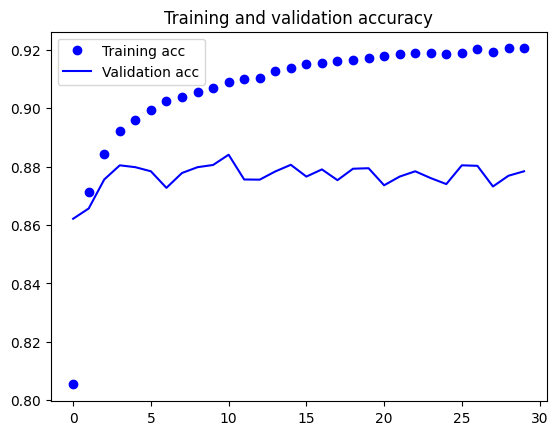

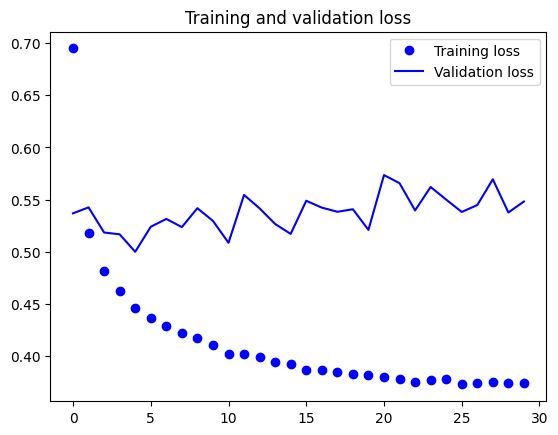

In [31]:
plotFromHistory(historyL2_1)

### Batch Normalisation

In [23]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

def create_convnet_with_l2_and_batchnorm(l2_penalty):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=l2(l2_penalty), input_shape=(64, 64, 1)))
    model.add(BatchNormalization())  # Add after Conv2D
    model.add(Conv2D(32, (3, 3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())  # Add after Conv2D
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())  # Add after Conv2D
    model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())  # Add after Conv2D
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())  # Add after Conv2D
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())  # Add after Dense
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())  # Add after Dense
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())  # Add after Dense
    model.add(Dense(N_CATEGORIES, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [24]:
modelbatchNorm = create_convnet_with_l2_and_batchnorm(0.0001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 60, 60, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                        

In [25]:
historyBatchNorm = modelbatchNorm.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=N_EPOCHS,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10


I0000 00:00:1707922651.115281     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8550/8550 [==============================] - 74s 8ms/step - loss: 1.0078 - accuracy: 0.7339 - val_loss: 0.7637 - val_accuracy: 0.8423
Epoch 2/10
8550/8550 [==============================] - 66s 8ms/step - loss: 0.8595 - accuracy: 0.8101 - val_loss: 0.7310 - val_accuracy: 0.8540
Epoch 3/10
8550/8550 [==============================] - 66s 8ms/step - loss: 0.8010 - accuracy: 0.8350 - val_loss: 0.6928 - val_accuracy: 0.8667
Epoch 4/10
8550/8550 [==============================] - 65s 8ms/step - loss: 0.7534 - accuracy: 0.8449 - val_loss: 0.6994 - val_accuracy: 0.8580
Epoch 5/10
8550/8550 [==============================] - 67s 8ms/step - loss: 0.7226 - accuracy: 0.8509 - val_loss: 0.6666 - val_accuracy: 0.8683
Epoch 6/10
8550/8550 [==============================] - 65s 8ms/step - loss: 0.7009 - accuracy: 0.8560 - val_loss: 0.6463 - val_accuracy: 0.8703
Epoch 7/10
8550/8550 [==============================] - 65s 8ms/step - loss: 0.6753 - accuracy: 0.8608 - val_loss: 0.7130 - val_accuracy: 0.8

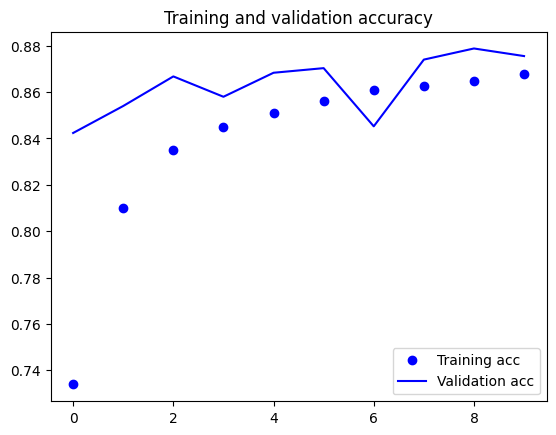

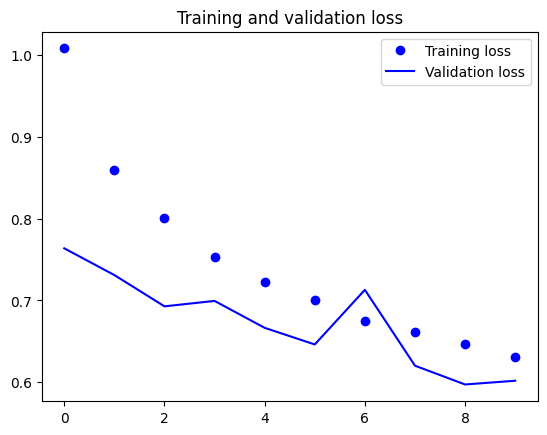

In [26]:
plotFromHistory(historyBatchNorm)

Underfitting was observed, after batch normalisation, hence we continue pushing the model until overfitting is observed.

The following epoch is pushed from epoch = 11 onwards.

In [27]:
historyBatchNorm2 = modelbatchNorm.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=20,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/20
8550/8550 [==============================] - 66s 8ms/step - loss: 0.6275 - accuracy: 0.8686 - val_loss: 0.6086 - val_accuracy: 0.8738
Epoch 2/20
8550/8550 [==============================] - 65s 8ms/step - loss: 0.6170 - accuracy: 0.8711 - val_loss: 0.6291 - val_accuracy: 0.8647
Epoch 3/20
8550/8550 [==============================] - 65s 8ms/step - loss: 0.6075 - accuracy: 0.8711 - val_loss: 0.5840 - val_accuracy: 0.8819
Epoch 4/20
8550/8550 [==============================] - 65s 8ms/step - loss: 0.5980 - accuracy: 0.8737 - val_loss: 0.5684 - val_accuracy: 0.8846
Epoch 5/20
8550/8550 [==============================] - 65s 8ms/step - loss: 0.5941 - accuracy: 0.8750 - val_loss: 0.6059 - val_accuracy: 0.8725
Epoch 6/20
8550/8550 [==============================] - 65s 8ms/step - loss: 0.5908 - accuracy: 0.8751 - val_loss: 0.5997 - val_accuracy: 0.8696
Epoch 7/20
8550/8550 [==============================] - 65s 8ms/step - loss: 0.5857 - accuracy: 0.8757 - val_loss: 0.5775 - val_ac

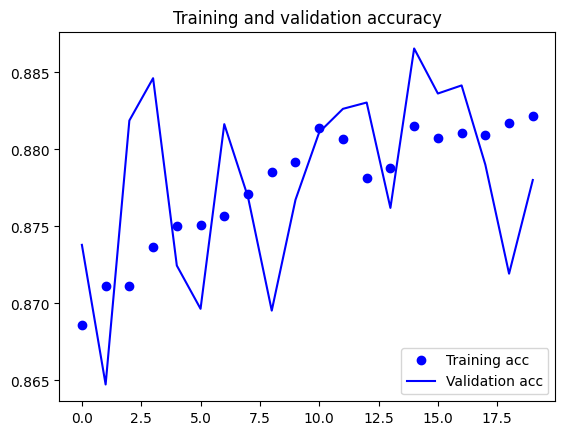

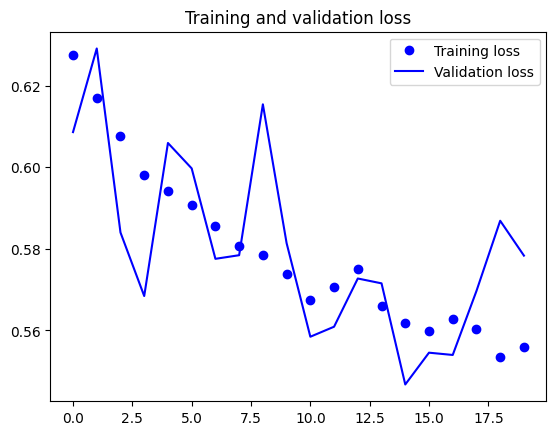

In [33]:
plotFromHistory(historyBatchNorm2)

It reached a maxima at 88.65% validation accuracy.

In [34]:
modelbatchNorm = create_convnet_with_l2_and_batchnorm(0.0001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_8 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 60, 60, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
historyBatchNorm = modelbatchNorm.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=8,
    epochs=25,
    validation_split=0.2  # 20% of training data will be used for validation
)

In [ ]:
# Saves the model as a Keras H5 (.h5) file.
modelbatchNorm.save("kaggle/working/modelbatchNorm.h5")
print("Model saved")

In [13]:
# import neptune

# # Create a Neptune run object
# run = neptune.init_run(
#     project="samuelkoh17/kaggle", 
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MDQ5OTJhYy1hMzAyLTQ1YWMtYThhZC05NTgyNWYxNjcyZjAifQ==", 
#     name="lotus-alligator", 
#     tags=["quickstart", "script"],  # optional
# )

# # Log a single value
# # Specify a field name ("seed") inside the run and assign a value to it
# run["seed"] = 0.42

# # Log a series of values
# from random import random

# epochs = 10
# offset = random() / 5

# for epoch in range(epochs):
#     acc = 1 - 2**-epoch - random() / (epoch + 1) - offset
#     loss = 2**-epoch + random() / (epoch + 1) + offset

#     run["accuracy"].append(acc)
#     run["loss"].append(loss)

# # Upload an image
# run["single_image"].upload("Lenna_test_image.png")

# # Download the MNIST dataset
# import mnist

# train_images = mnist.train_images()
# train_labels = mnist.train_labels()

# # Upload a series of images
# from neptune.types import File

# for i in range(10):
#     run["image_series"].append(
#         File.as_image(
#             train_images[i] / 255
#         ),  # You can upload arrays as images using the File.as_image() method
#         name=f"{train_labels[i]}",
#     )

# # Stop the connection and synchronize the data with the Neptune servers
# run.stop()

https://app.neptune.ai/samuelkoh17/kaggle/e/KAG-1
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 32 operations to synchronize with Neptune. Do not kill this process.
Error occurred during asynchronous operation processing: Cannot upload file /kaggle/working/Lenna_test_image.png: Path not found or is a not a file.
All 32 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/samuelkoh17/kaggle/e/KAG-1/metadata


In [30]:
# # Creating the ConvNet, adding a process each step of the way.
# model = Sequential()

# # The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
# model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
# #model.add(Conv2D(32, (3,3), activation="relu"))
# #model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Conv2D(64, (3,3), activation="relu"))

# # A resizing kind of error. Simplified image.
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Dropout layers ensure that we are not overfitting the model.
# #model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation="relu"))
# #model.add(Dropout(0.5))

# # The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
# model.add(Dense(N_CATEGORIES, activation="softmax"))
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
# model.summary()
# modelArc0 = model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_27 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 57600)             0         
                                                                 
 dense_20 (Dense)            (None, 128)               7372928   
                                                                 
 dense_21 (Dense)            (None, 12)                1548      
                                                      

In [29]:
# # Creating the ConvNet, adding a process each step of the way.
# model = Sequential()

# # The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
# model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
# model.add(Conv2D(32, (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Conv2D(64, (3,3), activation="relu"))

# # A resizing kind of error. Simplified image.
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Dropout layers ensure that we are not overfitting the model.
# #model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation="relu"))
# #model.add(Dropout(0.5))

# # The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
# model.add(Dense(N_CATEGORIES, activation="softmax"))
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
# model.summary()
# modelArc1 = model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_24 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 12544)            

In [21]:
# # Creating the ConvNet, adding a process each step of the way.
# model = Sequential()

# # The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
# model.add(Conv2D(32, kernel_size=(3 , 3), activation="relu", input_shape=(64,64,1)))
# model.add(Conv2D(32, (3,3), activation="relu"))
# model.add(Conv2D(32, (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Conv2D(64, (3,3), activation="relu"))

# # A resizing kind of error. Simplified image.
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Dropout layers ensure that we are not overfitting the model.
# #model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation="relu"))
# #model.add(Dropout(0.5))

# # The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
# model.add(Dense(N_CATEGORIES, activation="softmax"))
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
# model.summary()
# modelArc2 = model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 11, 11, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                 

In [22]:
# # Creating the ConvNet, adding a process each step of the way.
# model = Sequential()

# # The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
# model.add(Conv2D(32, kernel_size=(3 , 3), activation="relu", input_shape=(64,64,1)))
# model.add(Conv2D(32, (3,3), activation="relu"))
# model.add(Conv2D(32, (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Conv2D(64, (3,3), activation="relu"))
# model.add(Conv2D(64, (3,3), activation="relu"))

# # A resizing kind of error. Simplified image.
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Dropout layers ensure that we are not overfitting the model.
# #model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation="relu"))
# #model.add(Dropout(0.5))

# # The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
# model.add(Dense(N_CATEGORIES, activation="softmax"))
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
# model.summary()
# modelArc3 = model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 11, 11, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 64)          36928     
                                                      

In [31]:
# # Compiles and trains the model; the fit() function is the most important in actually creating the model.
# historyArc0 = modelArc0.fit(
#     np.array(resized_x_train),
#     np.array(Y_train),
#     batch_size=32,
#     epochs=N_EPOCHS,
#     validation_split=0.2  # 20% of training data will be used for validation
# )

Epoch 1/10
2138/2138 [==============================] - 18s 8ms/step - loss: 0.7853 - accuracy: 0.7597 - val_loss: 0.6066 - val_accuracy: 0.8150
Epoch 2/10
2138/2138 [==============================] - 16s 7ms/step - loss: 0.5402 - accuracy: 0.8332 - val_loss: 0.5689 - val_accuracy: 0.8232
Epoch 3/10
2138/2138 [==============================] - 16s 7ms/step - loss: 0.4773 - accuracy: 0.8507 - val_loss: 0.5889 - val_accuracy: 0.8228
Epoch 4/10
2138/2138 [==============================] - 16s 7ms/step - loss: 0.4369 - accuracy: 0.8619 - val_loss: 0.6281 - val_accuracy: 0.8241
Epoch 5/10
2138/2138 [==============================] - 16s 7ms/step - loss: 0.4086 - accuracy: 0.8706 - val_loss: 0.6896 - val_accuracy: 0.8083
Epoch 6/10
2138/2138 [==============================] - 16s 7ms/step - loss: 0.3857 - accuracy: 0.8769 - val_loss: 0.6892 - val_accuracy: 0.8199
Epoch 7/10
2138/2138 [==============================] - 16s 7ms/step - loss: 0.3634 - accuracy: 0.8844 - val_loss: 0.7232 - val_ac

In [32]:
# # Compiles and trains the model; the fit() function is the most important in actually creating the model.
# historyArc1 = modelArc1.fit(
#     np.array(resized_x_train),
#     np.array(Y_train),
#     batch_size=32,
#     epochs=N_EPOCHS,
#     validation_split=0.2  # 20% of training data will be used for validation
# )

Epoch 1/10
2138/2138 [==============================] - 15s 6ms/step - loss: 0.8179 - accuracy: 0.7535 - val_loss: 0.6758 - val_accuracy: 0.7960
Epoch 2/10
2138/2138 [==============================] - 13s 6ms/step - loss: 0.6828 - accuracy: 0.7935 - val_loss: 0.6574 - val_accuracy: 0.8028
Epoch 3/10
2138/2138 [==============================] - 13s 6ms/step - loss: 0.6932 - accuracy: 0.7962 - val_loss: 0.9742 - val_accuracy: 0.7663
Epoch 4/10
2138/2138 [==============================] - 13s 6ms/step - loss: 0.7893 - accuracy: 0.7767 - val_loss: 0.9359 - val_accuracy: 0.6964
Epoch 5/10
2138/2138 [==============================] - 13s 6ms/step - loss: 0.9252 - accuracy: 0.7404 - val_loss: 1.0568 - val_accuracy: 0.7164
Epoch 6/10
2138/2138 [==============================] - 13s 6ms/step - loss: 1.1240 - accuracy: 0.6753 - val_loss: 1.3481 - val_accuracy: 0.6380
Epoch 7/10
2138/2138 [==============================] - 13s 6ms/step - loss: 1.3138 - accuracy: 0.6027 - val_loss: 1.5755 - val_ac

In [ ]:
# # Compiles and trains the model; the fit() function is the most important in actually creating the model.
# historyArc2 = modelArc2.fit(
#     np.array(resized_x_train),
#     np.array(Y_train),
#     batch_size=32,
#     epochs=N_EPOCHS,
#     validation_split=0.2  # 20% of training data will be used for validation
# )

In [ ]:
# # Compiles and trains the model; the fit() function is the most important in actually creating the model.
# historyArc3 = modelArc3.fit(
#     np.array(resized_x_train),
#     np.array(Y_train),
#     batch_size=32,
#     epochs=N_EPOCHS,
#     validation_split=0.2  # 20% of training data will be used for validation
# )

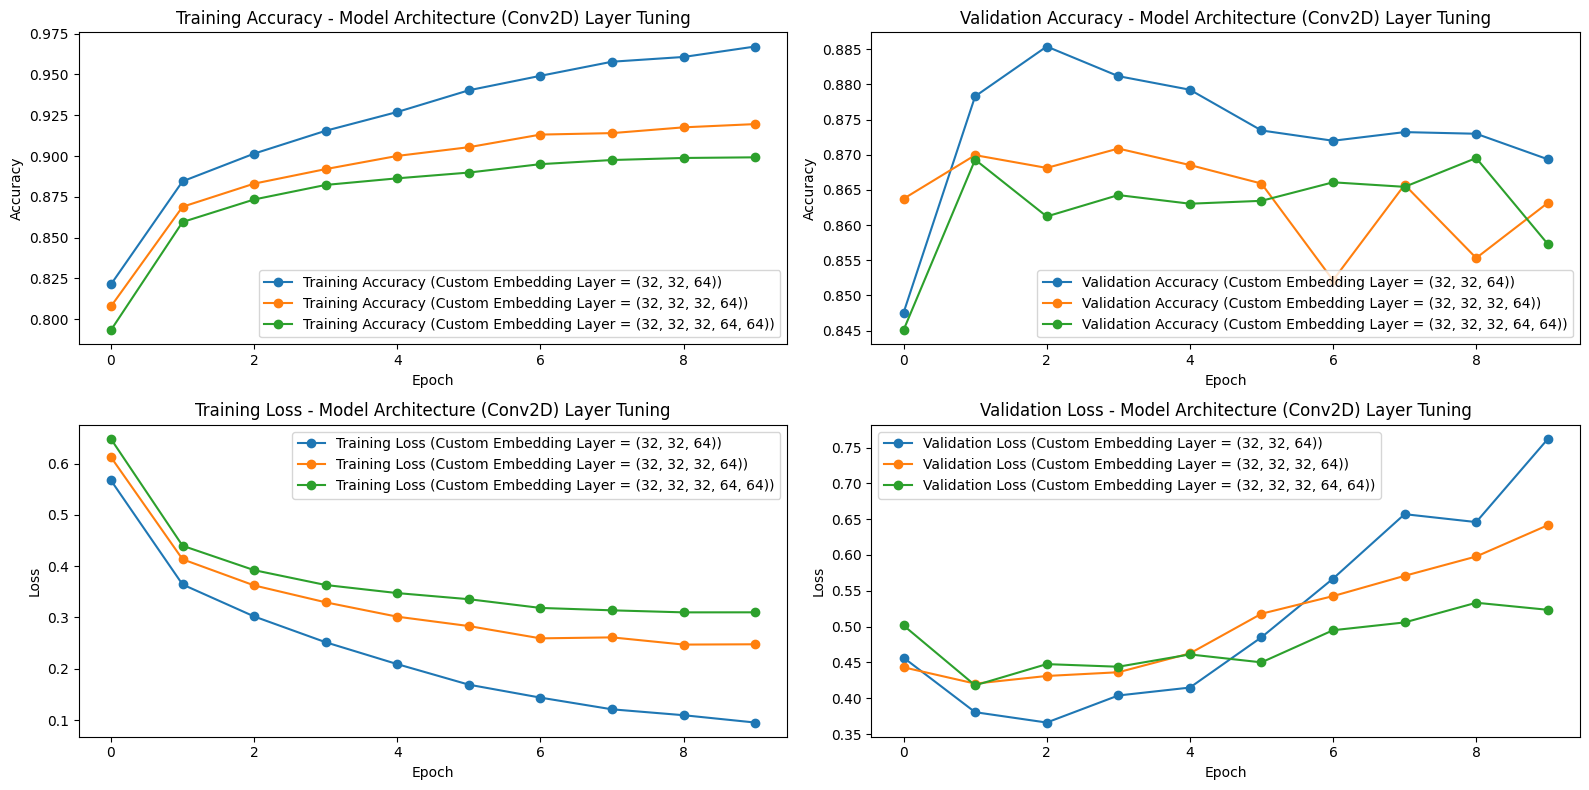

In [62]:
histories = [history, historyArc2, historyArc3]
title = 'Model Architecture (Conv2D) Layer Tuning'
hyperparam_name = 'Custom Embedding Layer'
hyperparam_values = [(32, 32, 64), (32, 32, 32, 64), (32, 32, 32, 64, 64)]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

In [ ]:
# # Creating the ConvNet, adding a process each step of the way.
# model = Sequential()

# # The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
# model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
# model.add(Conv2D(32, (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Conv2D(64, (3,3), activation="relu"))

# # A resizing kind of error. Simplified image.
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Dropout layers ensure that we are not overfitting the model.
# #model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(64, activation="relu"))
# model.add(Dense(64, activation="relu"))
# #model.add(Dropout(0.5))

# # The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
# model.add(Dense(N_CATEGORIES, activation="softmax"))
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
# modelDense1 = model

In [ ]:
# # Creating the ConvNet, adding a process each step of the way.
# model = Sequential()

# # The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
# model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
# model.add(Conv2D(32, (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Conv2D(64, (3,3), activation="relu"))

# # A resizing kind of error. Simplified image.
# model.add(MaxPooling2D(pool_size = (2,2)))

# # Dropout layers ensure that we are not overfitting the model.
# #model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(64, activation="relu"))
# model.add(Dense(64, activation="relu"))
# model.add(Dense(64, activation="relu"))
# #model.add(Dropout(0.5))

# # The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
# model.add(Dense(N_CATEGORIES, activation="softmax"))
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
# modelDense2 = model